In [1]:
import pandas as pd
from discovery_utils import PROJECT_DIR
from discovery_utils.horizon_scout import inference_bert
import re

from datetime import datetime

import os
import dotenv


# Load environment variables from .env file
dotenv.load_dotenv();

In [2]:
# Specify the path to your Parquet file
file_path = PROJECT_DIR / 'policy_scanning/data/HansardDebates.parquet'

# Load the Parquet file into a DataFrame + clean one more time
df_speeches = pd.read_parquet(file_path)

In [3]:
# Function to clean each speech
def clean_speech(speech):
    # Remove tabs
    speech = speech.replace('\t', '')
    
    # Replace multiple spaces with a single space
    speech = re.sub(r'\s+', ' ', speech)
    
    # Remove leading and trailing spaces
    speech = speech.strip()
    
    return speech

def lower_case(speech):
    return speech.lower()


In [4]:
def count_speeches_per_year(year_column, start_year, end_year): 
    
    dict_speeches_per_year = {}
    for year in range(start_year, end_year):
        count = 0
        for item in year_column:
            if item == str(year):
                count +=1
        dict_speeches_per_year[f"{year}"] = count

    return  dict_speeches_per_year

In [5]:
def normalize_speech_count(dict1, dict2):
    normalized_result = {}
    for key, value in dict1.items():
        if key in dict2:
            normalized_result[key] = value / dict2[key]
    
    return normalized_result

In [6]:
def divide_data_per_parliamentary_term(dataframe):
    dataframe['date'] = pd.to_datetime(dataframe['date'], format='%Y-%m-%d').dt.date

    #Step 1: create different datasets that include the speeches per presidential term
    list_2005_2010 = []
    list_2010_2015 = []
    list_2015_2017 = []
    list_2017_2019 = []
    list_2019_2024 = []

    #step 2, specify the start and end dates to divide the dataframe
    start_date_1 = datetime(2005, 5, 6).date()
    start_date_2 = datetime(2010, 5, 6).date()
    start_date_3 = datetime(2015, 5, 7).date()
    start_date_4 = datetime(2017, 6, 8).date()
    start_date_5 = datetime(2019, 7, 4).date()

    for index, row in dataframe.iterrows(): #change this because you are not using index xoxoxox
        if start_date_1 <= row['date'] <  start_date_2:
            list_2005_2010.append(row)
        elif start_date_2 <= row['date'] <  start_date_3:
            list_2010_2015.append(row)
        elif start_date_3 <= row['date'] <  start_date_4:
            list_2015_2017.append(row)
        elif start_date_4 <= row['date'] <  start_date_5:
            list_2017_2019.append(row)
        elif row['date'] >= start_date_5:
            list_2019_2024.append(row)

    df_2005_2010 = pd.DataFrame(list_2005_2010)
    df_2010_2015 = pd.DataFrame(list_2010_2015)
    df_2015_2017 = pd.DataFrame(list_2015_2017)
    df_2017_2019 = pd.DataFrame(list_2017_2019)
    df_2019_2024 = pd.DataFrame(list_2019_2024)

    return (df_2005_2010,df_2010_2015,df_2015_2017,df_2017_2019,df_2019_2024)

In [7]:
#you are not using index so change this!!!!!
def select_speeches(search_term, column_name, dataframe):
    list_speeches = []
    for index, row in dataframe.iterrows():
        speech = row[column_name]
        match = re.search(str(search_term), str(speech))
        if match:
            list_speeches.append(row)
    
    return list_speeches

## preprocessing

In [8]:
#Could also add this in the data collection step
df_speeches['speech'] = df_speeches['speech'].apply(clean_speech)
df_speeches['speech'] = df_speeches['speech'].apply(lower_case)


## Create dataframes for each parliamentary term

In [9]:
df_2005_2010,df_2010_2015,df_2015_2017,df_2017_2019,df_2019_2024 = divide_data_per_parliamentary_term(df_speeches)

In [10]:
#Change the name of this
list_df_hp_1 = select_speeches('heat pump', 'speech', df_2005_2010)
list_df_hp_2 = select_speeches('heat pump', 'speech', df_2010_2015)
list_df_hp_3 = select_speeches('heat pump', 'speech', df_2015_2017)
list_df_hp_4 = select_speeches('heat pump', 'speech', df_2017_2019)
list_df_hp_5 = select_speeches('heat pump', 'speech', df_2019_2024)
list_hp_all_years = list_df_hp_1 + list_df_hp_2 + list_df_hp_3 + list_df_hp_4 + list_df_hp_5

#create dataframes of heatpump speeches
hp_df_2005_2010 = pd.DataFrame(list_df_hp_1)
hp_df_2005_2010['speech'] = hp_df_2005_2010.apply(lambda row: row['speech'] + f"This speech was held in {row['year']} by {row['speakername']}. Party: {row['party_speaker']}",
    axis=1)
hp_df_2010_2015 = pd.DataFrame(list_df_hp_2)
hp_df_2010_2015['speech'] = hp_df_2010_2015.apply(lambda row: row['speech'] + f"This speech was held in {row['year']} by {row['speakername']}. Party: {row['party_speaker']}",
    axis=1)
hp_df_2015_2017 = pd.DataFrame(list_df_hp_3)
hp_df_2015_2017['speech'] = hp_df_2015_2017.apply(lambda row: row['speech'] + f"This speech was held in {row['year']} by {row['speakername']}. Party: {row['party_speaker']}",
    axis=1)
hp_df_2017_2019 = pd.DataFrame(list_df_hp_4)
hp_df_2017_2019['speech'] = hp_df_2017_2019.apply(lambda row: row['speech'] + f"This speech was held in {row['year']} by {row['speakername']}. Party: {row['party_speaker']}",
    axis=1)
hp_df_2019_2024 = pd.DataFrame(list_df_hp_5)
hp_df_2019_2024['speech'] = hp_df_2019_2024.apply(lambda row: row['speech'] + f"This speech was held in {row['year']} by {row['speakername']}. Party: {row['party_speaker']}",
    axis=1)

#We are also creating a dataframe for the entire framework as that will allow for comparison with other research --> ADD DATAFRAMES TOGETHER
df_heat_pumps = pd.DataFrame(list_hp_all_years) 

In [38]:
from discovery_utils.horizon_scout import inference_bert
import pandas as pd

In [39]:
# Load in the models
models = inference_bert.load_models(
    inference_bert.MODEL_PATHS,
    inference_bert.MISSIONS,
    gpu=False,
)

# Load the tokenizer
tokenizer = inference_bert.AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

In [43]:
df_speeches.columns

Index(['major_heading', 'minor_heading', 'speech', 'speech_id', 'speakername',
       'speaker_id', 'person_id', 'party_speaker', 'speech_type', 'year',
       'date'],
      dtype='object')

In [50]:
sub_df_ = df_speeches.sample(n=1000, random_state=1)  


In [51]:
sub_df_.shape

(1000, 11)

In [52]:
# Add the predicted mission labels
sub_df_ = sub_df_.pipe(
    inference_bert.bert_add_predictions,
    text_col="speech",
    bert_models=models,
    tokenizer=tokenizer,
    missions=inference_bert.MISSIONS,
    batch_size=inference_bert.BATCH_SIZE,
)

In [53]:
sub_df_

,major_heading,minor_heading,speech,speech_id,speakername,speaker_id,person_id,party_speaker,speech_type,year,date,ahl_bert_preds,asf_bert_preds,afs_bert_preds
1061250,Afghanistan: FCDO Update,None,i thank my hon. friend for his question. i kno...,uk.org.publicwhip/debate/2021-09-06d.52.2,Dominic Raab,NA,uk.org.publicwhip/person/24815,conservative,Start Answer,2021,2021-09-06,0,1,1
250606,PRIME MINISTER,Engagements,i would like to add my own expressions of symp...,uk.org.publicwhip/debate/2009-05-20b.1498.0,Nicholas Clegg,uk.org.publicwhip/member/1812,NA,liberal-democrat,NA,2009,2009-05-20,0,0,0
931234,CLIMATE ACTION AND EXTINCTION REBELLION,None,before i call the right hon. member for doncas...,uk.org.publicwhip/debate/2019-04-23a.601.0,John Bercow,NA,uk.org.publicwhip/person/10040,speaker,NA,2019,2019-04-23,0,1,0
511609,WAYS AND MEANS — Budget Resolutions and Econom...,amendment of the Law,i congratulate my hon. friend on being picked ...,uk.org.publicwhip/debate/2013-03-22b.1184.2,Iain Duncan Smith,uk.org.publicwhip/member/40167,NA,conservative,NA,2013,2013-03-22,0,1,0
53926,DEPUTY PRIME MINISTER,Housing Development,can the minister tell the house what proportio...,uk.org.publicwhip/debate/2006-02-01b.301.0,Michael Gove,uk.org.publicwhip/member/1858,NA,conservative,NA,2006,2006-02-01,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335144,Employment Retention,Clause 1 — polling days for parliamentary gene...,it is great to have another new entrant to the...,uk.org.publicwhip/debate/2010-11-16a.811.1,Chris Bryant,uk.org.publicwhip/member/40497,NA,labour,NA,2010,2010-11-16,0,0,0
912,Orders of the Day — Child Benefit Bill,None,will the right hon. lady give way?,uk.org.publicwhip/debate/2005-01-12a.322.4,John Bercow,uk.org.publicwhip/member/730,NA,conservative,NA,2005,2005-01-12,0,0,0
274477,OUTLAWRIES BILL,Debate on the Address — [1st Day],"unfortunately, i do not think the right hon. m...",uk.org.publicwhip/debate/2009-11-18d.55.2,Brooks Newmark,uk.org.publicwhip/member/1443,NA,conservative,NA,2009,2009-11-18,0,1,0
586696,PRIME MINISTER,Clause 2 — Removal of restriction on standing ...,will the right hon. gentleman give way?,uk.org.publicwhip/debate/2014-04-30a.911.0,Mark Harper,uk.org.publicwhip/member/40263,NA,conservative,NA,2014,2014-04-30,0,0,0


In [12]:
#compare length of speeches to examine the context window
store_len_speech = 0
longest_speech = ""
for index, row in df_heat_pumps.iterrows():
    
    len_sp = len(row['speech'])
    if len_sp > store_len_speech:
        store_len_speech = len_sp
        longest_speech = row['speech']     

### Select a random sample for relevance evaluation

In [13]:
#compute the average length of speeches
sum = 0
for index, row in df_heat_pumps.iterrows():
    len_speech = len(row['speech'])
    sum += len_speech

average_len_speech = sum/292
average_len_speech


3657.554794520548

In [13]:
import random #--> I have these speeches stored now in a word_document
# Define the range for "roughly the same as the average"
range_average = 0.1 * average_len_speech  # 10% range

#Create list with speeches divided by how long they are
short_speech = [item for item in df_heat_pumps['speech'] if len(item) < average_len_speech - range_average]
average_speech = [item for item in df_heat_pumps['speech'] if average_len_speech - range_average <= len(item) <= average_len_speech + range_average]
long_speech = [item for item in df_heat_pumps['speech'] if len(item) > average_len_speech + range_average]

#select a random sample of speeches to evaluate
low_sample = random.sample(short_speech, 5) 
av_sample = random.sample(average_speech, 5) 
high_sample = random.sample(long_speech, 5)

# Frequency analysis + Topic modelling

NOTE: trend analysis is done over the years so that it can be compared with other research on news papers

### Non-Normalized Trend analysis speeches containing the word heat pump(s)

In [14]:
hp_speeches_per_year = df_heat_pumps['year'].value_counts().sort_index()
print(hp_speeches_per_year)

year
2005     2
2006    11
2007     4
2008    20
2009    26
2010    20
2011    10
2012     2
2013     4
2014     1
2016     3
2017     3
2018     2
2019     7
2020     9
2021    58
2022    36
2023    61
2024    13
Name: count, dtype: int64


In [15]:
dict_hp_per_year = hp_speeches_per_year.to_dict()

In [16]:
dict_hp_per_year

{'2005': 2,
 '2006': 11,
 '2007': 4,
 '2008': 20,
 '2009': 26,
 '2010': 20,
 '2011': 10,
 '2012': 2,
 '2013': 4,
 '2014': 1,
 '2016': 3,
 '2017': 3,
 '2018': 2,
 '2019': 7,
 '2020': 9,
 '2021': 58,
 '2022': 36,
 '2023': 61,
 '2024': 13}

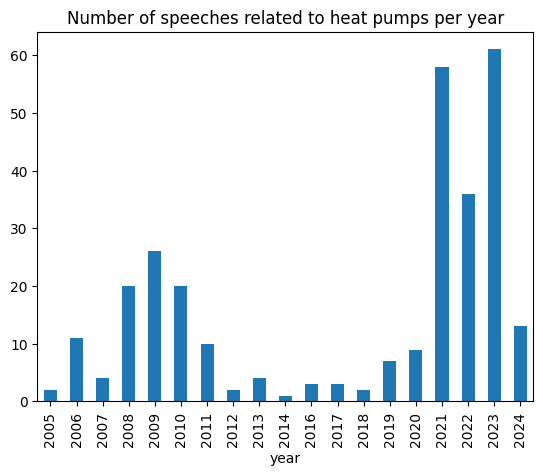

In [17]:
import matplotlib.pyplot as plt

# Assuming sorted_year_counts is your Series with the counts
hp_speeches_per_year.plot(kind='bar', title='Number of speeches related to heat pumps per year')

# Display the plot
plt.show()

### Create a graph with the normalized results, for a more informed comparison

In [18]:
dict_speeches_per_year = count_speeches_per_year(df_speeches['year'], 2005,2025)
normalized_dict = normalize_speech_count(dict_hp_per_year, dict_speeches_per_year)

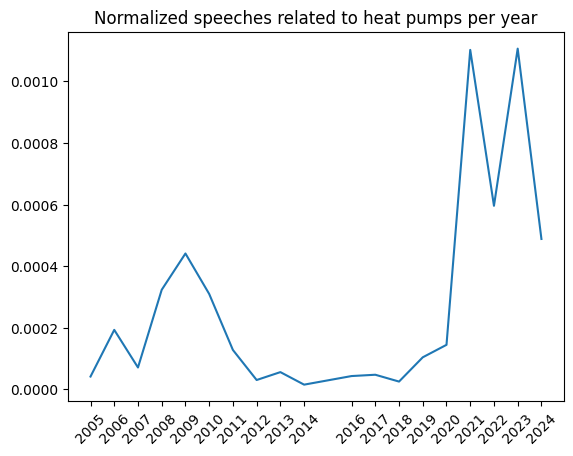

In [19]:
#change the dictionary back into a pandas.series so that I can plot it.
normalizes_series = pd.Series(normalized_dict)
normalizes_series.index = normalizes_series.index.astype(int)

pt = normalizes_series.plot(kind='line', title='Normalized speeches related to heat pumps per year')

# reset axis so that it shows every year
pt.set_xticks(normalizes_series.index)
pt.set_xticklabels(normalizes_series.index, rotation=45) 


# Display the plot
plt.show()

### This graph shows the total amount of speeches given by the party members over the entire time period and the proportion of which they talked about heat pumps

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
#create a dictionary that shows how many speeches each party gave every year write this into a function The dictionary probably 
#has as keys the year and then another dictionary with speeches per party
gb_year_total = df_speeches.groupby('year')
dictionary_party_per_year = {}
for year, group in gb_year_total:
    speech_per_party = group.groupby('party_speaker')
    dict_speeches_party = {}
    for party, group in speech_per_party:
        dict_speeches_party[party] = group.shape[0]

    dictionary_party_per_year[year] = dict_speeches_party
    


In [33]:
how_many_speeches_per_party_total = df_speeches['party_speaker'].value_counts(dropna=False)
dict_party_speeches_total = how_many_speeches_per_party_total.to_dict()
how_many_speeches_per_party_hp = df_heat_pumps['party_speaker'].value_counts(dropna=False)
dict_party_hp = how_many_speeches_per_party_hp.to_dict()
normalized_party_result = normalize_speech_count(dict_party_hp, dict_party_speeches_total)

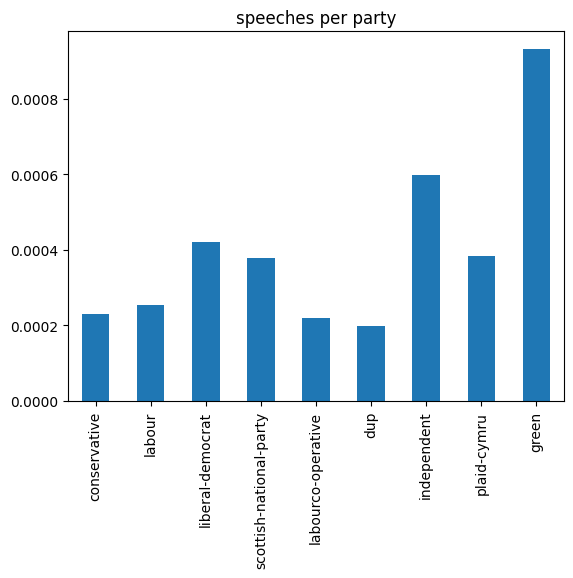

In [34]:
#This graph shows the proportion of speeches related to heatpumps in comparison to the total amount of speeches that were given by the party
normalizes_series = pd.Series(normalized_party_result)
normalizes_series.plot(kind='bar', title='speeches per party 2005-2024')

plt.show()

In [98]:
#We can also see the percentage of speeches about heat pumps in total and how much each party talked about it.
hp_total_dict = df_heat_pumps['year'].value_counts().sort_index()
gb_total_party_hp = df_heat_pumps.groupby('year')['party_speaker'].value_counts().unstack().fillna(0)

In [111]:
# Define the color map for parties
party_colors = {
    'conservative': '#1f77b4',  # blue
    'labour': '#ff7f0e',  # orange
    'liberal-democrat': '#800080', #purple
    'scottish-natinonal-party': '#FF69B4', #pink
    'labourco-operative': '#FF0000', #red
    'dup': '#FFD700', #yellow
    'independent': '#00FFFF', #cyan
    'plaid-cymru': '#FF00FF', #magnenta
    'green': '#2ca02c' #green    
}

<Figure size 30000x60000 with 0 Axes>

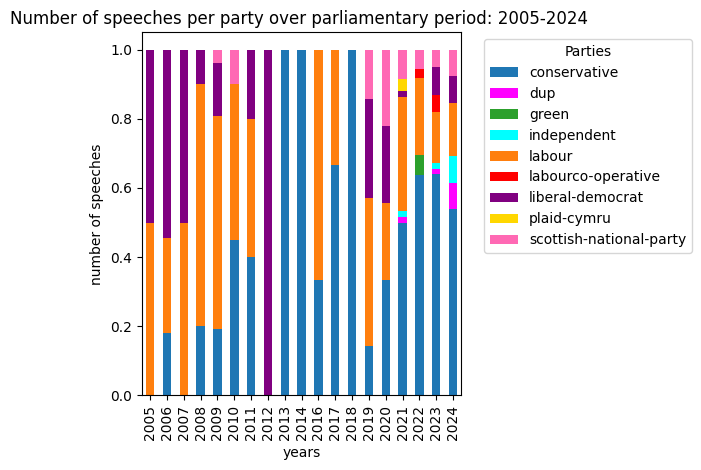

In [132]:
dict_party_total = change_group_into_dict(gb_total_party_hp)
dict_nor_term_ = normalize_speeches(dict_party_total, hp_total_dict)

party_colors = {
    'conservative': '#1f77b4',  # blue
    'labour': '#ff7f0e',  # orange
    'liberal-democrat': '#800080', #purple
    'scottish-national-party': '#FF69B4', #pink
    'labourco-operative': '#FF0000', #red
    'plaid-cymru': '#FFD700', #yellow
    'independent': '#00FFFF', #cyan
    'dup': '#FF00FF', #magnenta
    'green': '#2ca02c' #green    
}

df_T = pd.DataFrame(dict_nor_term_).T
plt.figure(figsize=(300, 600)) 

colors = [party_colors[party] for party in df_T.columns]
df_T.plot(kind='bar', stacked=True, color=colors)

plt.xlabel('years')
plt.ylabel('number of speeches')
plt.title('Number of speeches per party over parliamentary period: 2005-2024 ')
plt.legend(title='Parties', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Now do the above per parliamentary term

In [68]:
def normalize_speeches(dict_party, dict_total):
    dict_noralized = {}
    for key, value in dict_party.items():
        dict_values = {}
        if key in dict_total:
            total_speeches = dict_total[key]
            for k, v in value.items():
                nor_value = v / total_speeches
                dict_values[k] = nor_value
        dict_noralized[key] = dict_values
    
    return dict_noralized
    

In [80]:
def change_group_into_dict(gb_dataframe):
    dict_year_hp_party = {}
    for group, row in gb_dataframe.iterrows():
        dict_ = row.to_dict()
        dict_year_hp_party[group] = dict_
    return dict_year_hp_party

In [140]:
def create_graph(normalized_dict, period):
    df_T = pd.DataFrame(normalized_dict).T

    plt.figure(figsize=(10, 6))
    
    # colors = [colors[party] for party in df_T.columns]
    df_T.plot(kind='bar', stacked=True)
    
    plt.xlabel(f'years')
    plt.ylabel('number of speeches')
    plt.title(f'Number of speeches per party over parliamentary period: {period} ')
    plt.legend(title='Parties', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

In [75]:
#Get the hp speech count per year
hp_pt1_dict = hp_df_2005_2010['year'].value_counts().sort_index()
hp_pt2_dict = hp_df_2010_2015['year'].value_counts().sort_index()
hp_pt3_dict = hp_df_2015_2017['year'].value_counts().sort_index()
hp_pt4_dict = hp_df_2017_2019['year'].value_counts().sort_index()
hp_pt5_dict = hp_df_2019_2024['year'].value_counts().sort_index()

In [89]:
#Get the speech count per party
gb_year_5_10_hp = hp_df_2005_2010.groupby('year')['party_speaker'].value_counts().unstack().fillna(0)
gb_year_10_15_hp = hp_df_2010_2015.groupby('year')['party_speaker'].value_counts().unstack().fillna(0)
gb_year_15_17_hp = hp_df_2015_2017.groupby('year')['party_speaker'].value_counts().unstack().fillna(0)
gb_year_17_19_hp = hp_df_2017_2019.groupby('year')['party_speaker'].value_counts().unstack().fillna(0)
gb_year_19_24_hp = hp_df_2019_2024.groupby('year')['party_speaker'].value_counts().unstack().fillna(0)

<Figure size 1000x600 with 0 Axes>

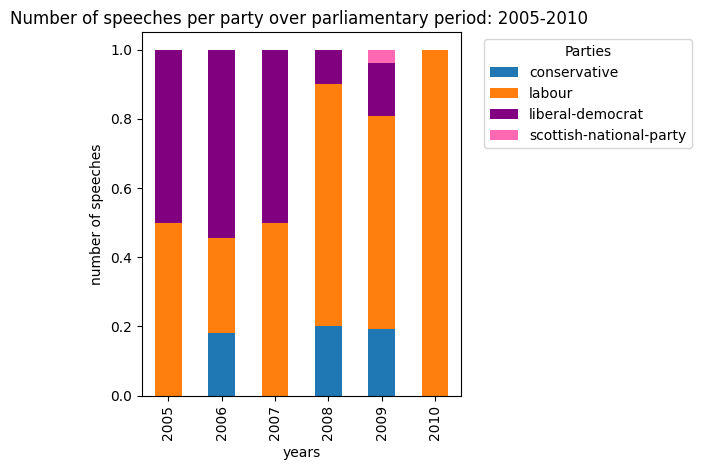

In [133]:
dict_party_1 = change_group_into_dict(gb_year_5_10_hp)
dict_nor_term_1 = normalize_speeches(dict_party_1, hp_pt1_dict)
create_graph(dict_nor_term_1, '2005-2010', party_colors)

<Figure size 1000x600 with 0 Axes>

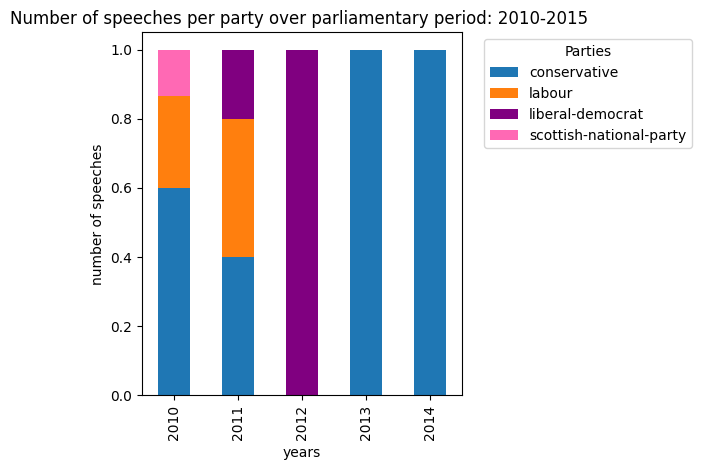

In [134]:
dict_party_2 = change_group_into_dict(gb_year_10_15_hp)
dict_nor_term_2 = normalize_speeches(dict_party_2, hp_pt2_dict)
create_graph(dict_nor_term_2, '2010-2015', party_colors)

<Figure size 1000x600 with 0 Axes>

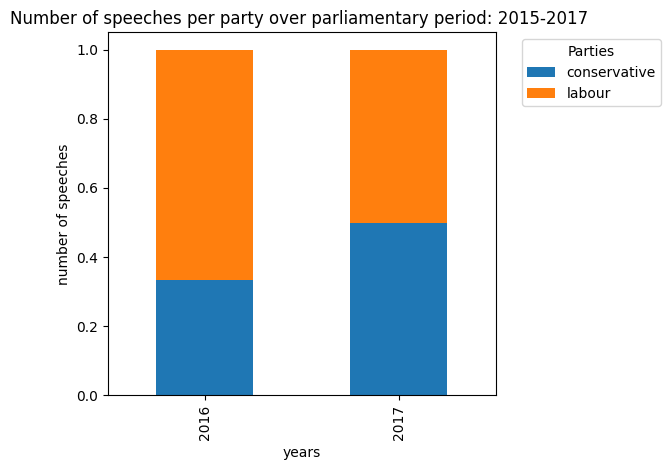

In [135]:
dict_party_3 = change_group_into_dict(gb_year_15_17_hp)
dict_nor_term_3 = normalize_speeches(dict_party_3, hp_pt3_dict)
create_graph(dict_nor_term_3, '2015-2017', party_colors)

<Figure size 1000x600 with 0 Axes>

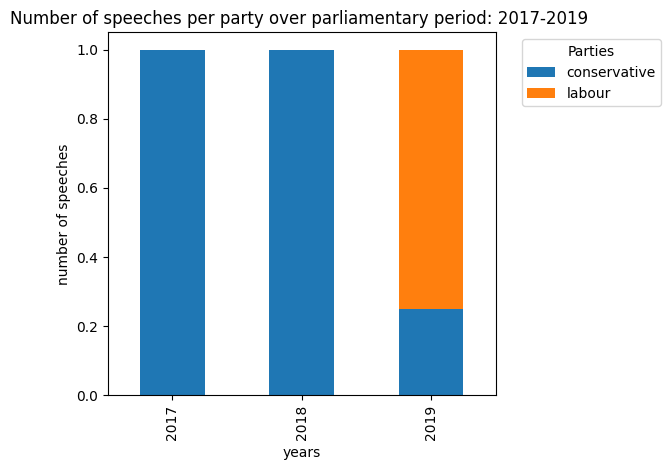

In [136]:
dict_party_4 = change_group_into_dict(gb_year_17_19_hp)
dict_nor_term_4 = normalize_speeches(dict_party_4, hp_pt4_dict)
create_graph(dict_nor_term_4, '2017-2019', party_colors)

<Figure size 1000x600 with 0 Axes>

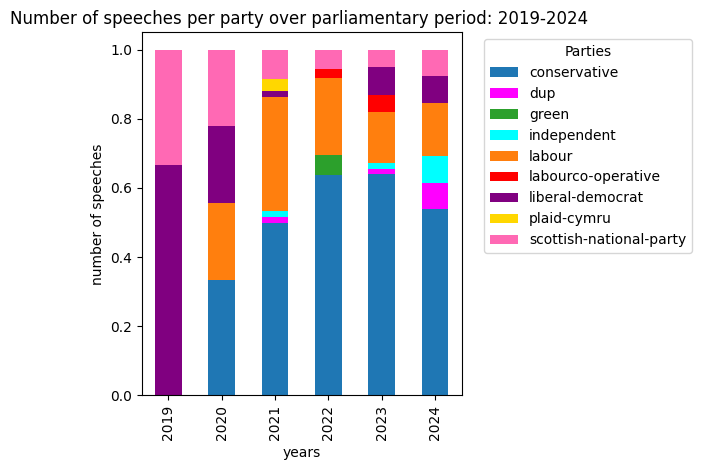

In [137]:
dict_party_5 = change_group_into_dict(gb_year_19_24_hp)
dict_nor_term_5 = normalize_speeches(dict_party_5, hp_pt5_dict)
create_graph(dict_nor_term_5, '2019-2024', party_colors)

# Now we also want to see which speaker is talking the most

In [171]:
most_common_speaker_1 = hp_df_2005_2010['speakername'].value_counts().head()
most_common_speaker_2 = hp_df_2010_2015['speakername'].value_counts().head()
most_common_speaker_3 = hp_df_2015_2017['speakername'].value_counts().head()
most_common_speaker_4 = hp_df_2017_2019['speakername'].value_counts().head()
most_common_speaker_5 = hp_df_2019_2024['speakername'].value_counts().head()

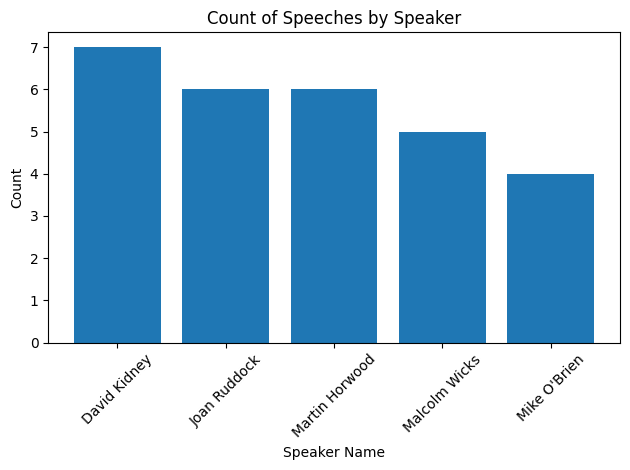

In [179]:
# Create a bar chart
plt.bar(most_common_speaker_1.keys(), most_common_speaker_1.values)
plt.xlabel('Speaker Name')
plt.ylabel('Count')
plt.title('Count of Speeches by Speaker, 2005-2010')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

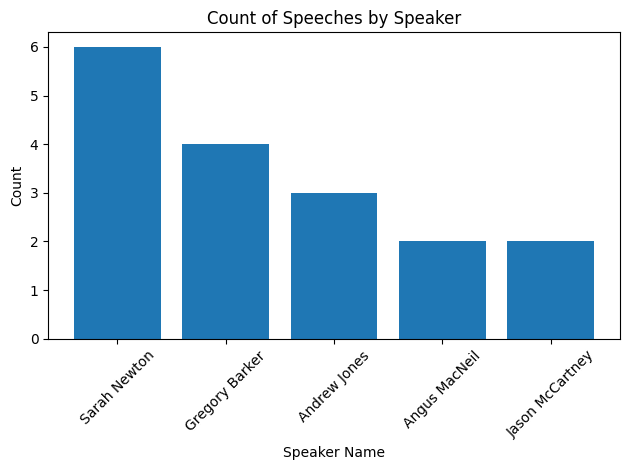

In [180]:
# Create a bar chart
plt.bar(most_common_speaker_2.keys(), most_common_speaker_2.values)
plt.xlabel('Speaker Name')
plt.ylabel('Count')
plt.title('Count of Speeches by Speaker, 2010-2015')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

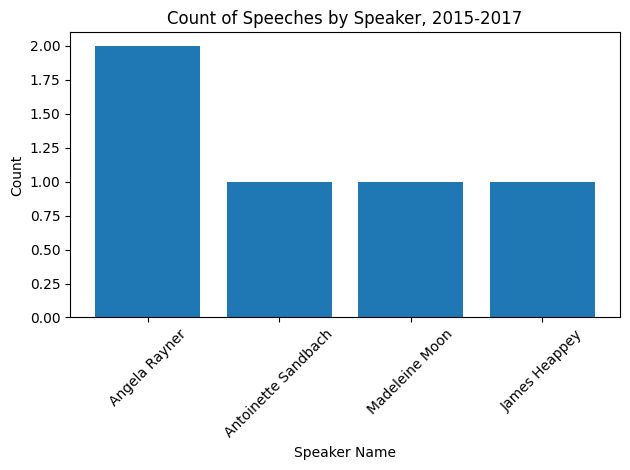

In [181]:
plt.bar(most_common_speaker_3.keys(), most_common_speaker_3.values)
plt.xlabel('Speaker Name')
plt.ylabel('Count')
plt.title('Count of Speeches by Speaker, 2015-2017')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

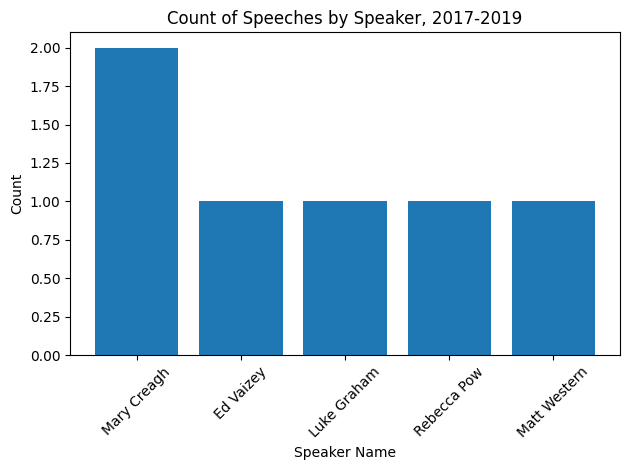

In [182]:
plt.bar(most_common_speaker_4.keys(), most_common_speaker_4.values)
plt.xlabel('Speaker Name')
plt.ylabel('Count')
plt.title('Count of Speeches by Speaker, 2017-2019')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

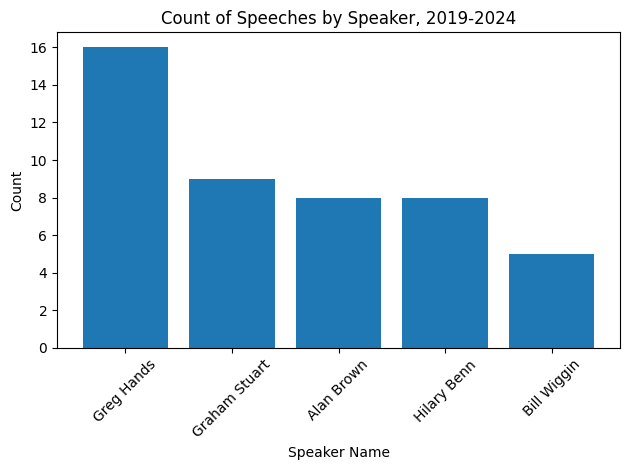

In [183]:
plt.bar(most_common_speaker_5.keys(), most_common_speaker_5.values)
plt.xlabel('Speaker Name')
plt.ylabel('Count')
plt.title('Count of Speeches by Speaker, 2019-2024')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Topic modelling

In [140]:
#create a list with all the sentences that contain heat pumps:
#Do think about hon. member please xxx
heat_pump_sentences = []
dates_hp_sentences = []
for index, row in df_heat_pumps.iterrows():
    speech = row['speech']
    single_sentences = re.split(r'(?<=[.!?]) +', speech.strip())
    for sentence in single_sentences:
        match = re.search('heat pump', sentence)
        if match:
            heat_pump_sentences.append(sentence)
            dates_hp_sentences.append(row['date'])   


In [141]:
from bertopic import BERTopic


In [142]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer with English stop words
vectorizer_model = CountVectorizer(stop_words="english")

# Initialize BERTopic with the vectorizer model
topic_model = BERTopic(vectorizer_model=vectorizer_model)
topics, prob = topic_model.fit_transform(heat_pump_sentences)

INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: mps


In [143]:
# Print the topics and their corresponding probabilities
for idx, prob in enumerate(prob):
    print(f"Document {idx}: Topic {topics[idx]}, Probability: {prob}")

Document 0: Topic -1, Probability: 0.0
Document 1: Topic 0, Probability: 0.7009067545432773
Document 2: Topic 0, Probability: 0.6985252576363596
Document 3: Topic 0, Probability: 0.6105517736711201
Document 4: Topic -1, Probability: 0.0
Document 5: Topic 0, Probability: 0.6325915656619189
Document 6: Topic -1, Probability: 0.0
Document 7: Topic 4, Probability: 0.6979447333200615
Document 8: Topic -1, Probability: 0.0
Document 9: Topic 3, Probability: 1.0
Document 10: Topic 3, Probability: 1.0
Document 11: Topic 3, Probability: 0.6870996972720772
Document 12: Topic 3, Probability: 1.0
Document 13: Topic 3, Probability: 0.679782626240654
Document 14: Topic -1, Probability: 0.0
Document 15: Topic 0, Probability: 0.6527469137998321
Document 16: Topic -1, Probability: 0.0
Document 17: Topic -1, Probability: 0.0
Document 18: Topic -1, Probability: 0.0
Document 19: Topic -1, Probability: 0.0
Document 20: Topic -1, Probability: 0.0
Document 21: Topic 6, Probability: 0.9956899318377185
Document

In [144]:
topic_model.visualize_barchart(top_n_topics=len(set(topic_model.topics_)))

In [145]:
fig = topic_model.visualize_documents(heat_pump_sentences, width=800, height=500)

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

In [146]:
fig

In [147]:
string_dates_hp_sentences = [str(item) for item in dates_hp_sentences]

In [148]:
#apply dynamic topic modelling using BERTopic
topics_over_time = topic_model.topics_over_time(heat_pump_sentences, string_dates_hp_sentences, nr_bins=20)

In [149]:
topic_model.visualize_topics_over_time(topics_over_time)

# Ask openAI to get the context in which heatpumps are mentioned for each parliamentary speech + 3A-CoT

In [13]:
#Select the longest speeches so that you can see if they work with the context window
list_length = []
for item in df_heat_pumps['speech']:
    list_length.append(len(item))


In [14]:
sorted_list = sorted(list_length, reverse = True)

In [15]:
sorted_list

[107816,
 20336,
 18329,
 17587,
 17587,
 16990,
 16981,
 16282,
 14482,
 14290,
 13740,
 13241,
 12745,
 12529,
 11312,
 11180,
 11084,
 10866,
 10749,
 10681,
 10036,
 9998,
 8909,
 8860,
 8422,
 8325,
 8204,
 8166,
 8052,
 7993,
 7934,
 7750,
 7593,
 7592,
 7440,
 7424,
 7412,
 7334,
 7329,
 7327,
 7282,
 7270,
 7268,
 7228,
 7038,
 6957,
 6895,
 6742,
 6711,
 6573,
 6568,
 6542,
 6493,
 6471,
 6360,
 6165,
 6071,
 6051,
 6014,
 5823,
 5810,
 5722,
 5436,
 5340,
 5334,
 5247,
 5211,
 4896,
 4890,
 4880,
 4864,
 4851,
 4826,
 4825,
 4723,
 4698,
 4619,
 4617,
 4584,
 4481,
 4463,
 4388,
 4364,
 4278,
 4173,
 4125,
 4117,
 4036,
 4010,
 3915,
 3882,
 3867,
 3805,
 3773,
 3733,
 3630,
 3556,
 3504,
 3485,
 3452,
 3400,
 3374,
 3359,
 3349,
 3282,
 3282,
 3262,
 3243,
 3182,
 3108,
 3102,
 3051,
 3039,
 3029,
 2995,
 2990,
 2968,
 2876,
 2875,
 2857,
 2838,
 2803,
 2798,
 2774,
 2762,
 2639,
 2441,
 2434,
 2377,
 2350,
 2344,
 2321,
 2250,
 2242,
 2241,
 2184,
 2106,
 2103,
 2101,
 2097

In [17]:
longest_string = None
for index, item in df_heat_pumps.iterrows():
    if len(item['speech']) >= 107816:
        print(item['date'])
        print(index)
        longest_string = item

2022-12-13
1139148


In [18]:
df_heat_pumps.shape

(292, 11)

In [26]:
longest_spee = None
for index, item in hp_df_2019_2024.iterrows():
    if item['year'] == '2022':
        # print(len(item['speech']))
        len_hihi = len(item['speech'])
        if len_hihi == 107878:
            longest_spee = item['speech']

In [27]:
longest_spee

'with this it will be convenient to discuss the following: government new clause 49—community land auction arrangements and their purpose. government new clause 50—power to permit community land auction arrangements. government new clause 51—application of cla receipts. government new clause 52—duty to pass cla receipts to other persons. government new clause 53—use of cla receipts in an area to which section (duty to pass cla receipts to other persons)(1) duty does not relate. government new clause 54—cla infrastructure delivery strategy. government new clause 55—power to provide for authorities making joint local plans. government new clause 56—parliamentary scrutiny of pilot. government new clause 57—cla regulations: further provision and guidance. government new clause 58—expiry of part 4a. government new clause 59—interpretation of part 4a. government new clause 60—street votes: community infrastructure levy. government new clause 63—marine licensing. government new clause 64—fees

In [28]:
import tiktoken
# Load the GPT-3.5 tokenizer
encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")

# Encode the text
tokens = encoding.encode(longest_spee)

# Print the token values
len(tokens)



22456

In [29]:
MAX_TOKENS = 16385
number_of_parts = (22440 // MAX_TOKENS) + 1
print(number_of_parts)

# Calculate the number of parts the string needs to be split into
length_parts = (len(longest_spee) // number_of_parts)
print(length_parts)
surplus = len(longest_spee) % number_of_parts
print(surplus)

list_parts = []
start_point = 0

for index in range(number_of_parts):
    end_point = start_point + length_parts + (1 if index < surplus else 0)
    list_parts.append(longest_spee[start_point:end_point])
    start_point = end_point
    
part_about_hp = []
for item in list_parts:
    match = re.search('heat pump', item)
    if match:
        part_about_hp.append(item)


for index, item in hp_df_2019_2024.iterrows():
    if item['year'] == '2022':
        len_hihi = len(item['speech'])
        if len_hihi == 107878:
            hp_df_2019_2024.loc[index, 'speech'] = part_about_hp[0]



2
53939
0


# Use the 3A-CoT to summarize the data per presidential term

In [19]:
from langfuse.openai import openai
client = openai.OpenAI(api_key=os.environ["OPENAI_API_KEY"])

In [20]:
!echo $LANGFUSE_HOST

https://langfuse.dap-tools.uk


In [21]:
import tiktoken
# Load the GPT-3.5 tokenizer
encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")

In [22]:
def attend_prompt(text, questions):
    # Define prompts for GPT-3.5 to extract specific information
    prompts = questions
    
    responses = []
    for prompt in prompts:
        # Combine the article content with the user's prompt
        combined_content = f"speech: {text}\n\nUser: {prompt}"

        simple_prompt = [{"role": "user", "content": combined_content}]

        chatgpt_output = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=simple_prompt,
            temperature=0.3,
            max_tokens=1000,
        )
        gpt_output = chatgpt_output.to_dict()
        message_content = gpt_output['choices'][0]['message']['content']
        responses.append(message_content)
    
    return responses

In [23]:
from langfuse.decorators import langfuse_context, observe

@observe()
def Arrange_prompt(key_info_MD, question):
    prompt = question
    combined_content = f"Information: {key_info_MD}\n\nUser: {prompt}"

    simple_prompt = [{"role": "user", "content": combined_content}]
    
    chatgpt_output = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=simple_prompt,
            temperature=0.3,
            max_tokens=1000,
        )
    gpt_output = chatgpt_output.to_dict()
    response = gpt_output['choices'][0]['message']['content']
    return response

In [24]:
from langfuse.decorators import langfuse_context, observe

@observe()
def final_summary(original_docs, key_info):
    langfuse_context.update_current_trace
    prompt = "Based on the above speeches and key information, write a complete summary. Make sure to include key information from all the documents."
    combined_content = f"speeches: {original_docs}\n\nKey information: {key_info}: {prompt}"

    simple_prompt = [{"role": "user", "content": combined_content}]

    chatgpt_output = openai.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=simple_prompt,
            temperature=0.5,
            max_tokens=1000,
        )
    
    gpt_output = chatgpt_output.to_dict()
    response = gpt_output['choices'][0]['message']['content']
    return response

# Write the code for getting the key information from every speech

In [24]:
#Generate the answers using the LLM to see the wording of the output
prompts = ['what is the context in which heat pumps are mentioned given the speech?', 'What is the name of the speaker?', 'In what year was the speech given?',
             'To which party does the speaker belong?']

In [25]:
def retrieve_info(data, column_name):
    list_with_info = []
    for item in data[column_name]:
        #check if it does not exceed max context for the LLM:
        tokens = encoding.encode(item)
        total_tokens = len(tokens)
        if total_tokens > 16385:
            item_split = divide_speech(item, total_tokens) #this returns a list of items
            for part in item_split:
                match = re.search('heat pump', part)
                if match: 
                    list_with_info.append(attend_prompt(item, prompts))
        else: 
            list_with_info.append(attend_prompt(item, prompts))
    
    return list_with_info

In [27]:
hp_df_2005_2010.shape

(68, 11)

In [30]:
key_info_05_10 = retrieve_info(hp_df_2005_2010, 'speech')

In [32]:
key_info_10_15 = retrieve_info(hp_df_2010_2015, 'speech')

In [33]:
key_info_15_17 = retrieve_info(hp_df_2015_2017, 'speech')

In [34]:
key_info_17_29 = retrieve_info(hp_df_2017_2019, 'speech')

In [36]:
variables_2 = {'variable_1': key_info_05_10,
                'variable2': key_info_10_15,
                'variable3': key_info_15_17,
                'variable4': key_info_17_29,
                }

In [37]:
import pickle
with open('/Users/rinskejongma/discovery_utils/policy_scanning/data/variables_2.pkl', 'wb') as file:
    pickle.dump(variables_2, file)

In [23]:
# mid_index = len(key_info_05_10) // 2
# list1_05_10 = key_info_05_10[:mid_index]  
# list2_05_10 = key_info_05_10[mid_index:]  

In [92]:
quarter_length = len(key_info_19_24) // 4
list1_19_24 = key_info_19_24[:quarter_length]  # First quarter
list2_19_24 = key_info_19_24[quarter_length:2 * quarter_length]  # Second quarter
list3_19_24 = key_info_19_24[2 * quarter_length:3 * quarter_length]  # Third quarter
list4_19_24 = key_info_19_24[3 * quarter_length:]  # Fourth quarter

In [97]:
_1_19_24_string = ""
for item in list1_19_24:
    for string in item:
        _1_19_24_string += string + " "

_2_19_24_string = ""
for item in list2_19_24:
    for string in item:
        _2_19_24_string += string + " "

_3_19_24_string = ""
for item in list3_19_24:
    for string in item:
        _3_19_24_string += string + " "

_4_19_24_string = ""
for item in list4_19_24:
    for string in item:
        _4_19_24_string += string + " "

In [98]:
len(_1_19_24_string)

27008

In [99]:
# Encode the input text to get tokens
tokens = encoding.encode(_1_19_24_string)
print(len(tokens))

num_parts = len(tokens) // 4000
print(num_parts)
remainder = len(tokens) % 4000
print(remainder)

5049
1
1049


In [27]:
num_parts = len(tokens) // 4000
print(num_parts)
remainder = len(tokens) % 4000
print(remainder)

0
3938


In [101]:
s_1_ummary_19_24 = Arrange_prompt(_1_19_24_string)
s_2_ummary_19_24 = Arrange_prompt(_2_19_24_string)
s_3_ummary_19_24 = Arrange_prompt(_3_19_24_string)
s_4_ummary_19_24 = Arrange_prompt(_4_19_24_string)


In [103]:
import nest_asyncio
from datasets import Dataset 
from ragas.metrics import summarization_score
from ragas import evaluate
# from asyncio import run

nest_asyncio.apply()


data_samples = {
    'contexts' : [[_1_19_24_string]],
    'summary': [s_1_ummary_19_24]
}
dataset = Dataset.from_dict(data_samples)
score = evaluate(dataset,metrics=[summarization_score])
score.to_pandas()

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Exception in thread Thread-167:
Traceback (most recent call last):
  File "/Users/rinskejongma/.pyenv/versions/3.10.11/lib/python3.10/asyncio/tasks.py", line 232, in __step
    result = coro.send(None)
  File "/Users/rinskejongma/discovery_utils/.venv/lib/python3.10/site-packages/langchain_core/language_models/chat_models.py", line 868, in _agenerate_with_cache
    result = await self._agenerate(
  File "/Users/rinskejongma/discovery_utils/.venv/lib/python3.10/site-packages/langchain_openai/chat_models/base.py", line 674, in _agenerate
    response = await self.async_client.create(**payload)
  File "/Users/rinskejongma/discovery_utils/.venv/lib/python3.10/site-packages/langfuse/openai.py", line 522, in _wrap_async
    openai_response = await wrapped(**arg_extractor.get_openai_args())
  File "/Users/rinskejongma/discovery_utils/.venv/lib/python3.10/site-packages/openai/resources/chat/completions.py", line 1289, in create
    return await self._post(
  File "/Users/rinskejongma/discovery

ExceptionInRunner: The runner thread which was running the jobs raised an exeception. Read the traceback above to debug it. You can also pass `raise_exceptions=False` incase you want to show only a warning message instead.

# Ask the LLM to get topics

In [136]:
# prompt_1 = 'Given the key information can you identify the two main topics surrounding heat pumps?'
# prompt_2 = 'Given the key information, which party spoke the most about heat pumps?'
prompt_3 = 'Given the key information, which speaker spoke the most about heat pumps?'
prompt_4 = 'What are the top 5 speakers in relation to heat pumps, given the key information?'

In [137]:
# response_1_5_10 = Arrange_prompt(key_info_05_10, prompt_1)
# response_2_5_10 = Arrange_prompt(key_info_05_10, prompt_2)
response_3_5_10 = Arrange_prompt(key_info_05_10, prompt_3)
response_4_5_10 = Arrange_prompt(key_info_05_10, prompt_4)

In [138]:
response_3_5_10

'The speaker who spoke the most about heat pumps based on the provided information is David Kidney, who mentioned heat pumps in multiple speeches given in 2009 and 2010.'

In [139]:
response_4_5_10

'Based on the key information provided, the top 5 speakers in relation to heat pumps are:\n\n1. David Kidney\n2. Joan Ruddock\n3. Malcolm Wicks\n4. Martin Horwood\n5. Andrew Dismore'

### Select the information per parliamentary term

In [122]:
#create a dataframe
df_2015_2017 = pd.DataFrame(list_df_hp_3)
df_2015_2017['speech'] = df_2015_2017.apply(
    lambda row: row['speech'] + f"This speech was held in {row['year']} by {row['speakername']}. Party: {row['party_speaker']}",
    axis=1)

In [312]:
df_2010_2015 = pd.DataFrame(list_df_hp_2)
df_2010_2015['speech'] = df_2010_2015.apply(
    lambda row: row['speech'] + f"This speech was held in {row['year']} by {row['speakername']}. Party: {row['party_speaker']}",
    axis=1)

In [314]:
df_2010_2015.shape

(32, 11)

In [315]:
#Generate the answers using the LLM to see the wording of the output
prompts = ['what is the context in which heat pumps are mentioned given the speech?', 'What is the name of the speaker?', 'In what year was the speech given?',
             'To which party does the speaker belong?']

In [316]:
list_responses_2010_2015 = []
for item in df_2010_2015['speech']:
    list_responses_2010_2015.append(attend_prompt(item, prompts))

In [325]:
def divide_list(lst):
    n = len(lst)
    part_size = n // 4
    return [
        lst[i * part_size:(i + 1) * part_size] for i in range(4)
    ] + [lst[4 * part_size:]]  # Add remaining elements if n is not a multiple

In [321]:
#Write all the speeches together, find a better way to do this later I guess.
new_string = ""
_2010_2015_string = ""
for item in list_responses_2010_2015:
    for string in item:
        _2010_2015_string += string + " "





In [318]:
first_arrange_attempt = Arrange_prompt(_2010_2015_string)
first_arrange_attempt
#split this into sentences: 
sentences_summary = re.split(r'[.!?]', first_arrange_attempt)   

"The information provided discusses various speeches given between 2010 and 2014 by politicians from different parties in the UK, highlighting the importance of heat pumps in promoting renewable energy, energy efficiency, and reducing carbon emissions. The speakers mention the role of heat pumps in the development of a low-carbon economy, the government's support for renewable energy technologies, and the potential benefits of utilizing heat pumps in homes and businesses. The speeches also address concerns about government policies, such as the Renewable Heat Incentive, and the need for continued support for renewable energy initiatives."

In [322]:
sentences_summary = re.split(r'[.!?]', first_arrange_attempt)   

In [323]:
len(sentences_summary)

4

In [328]:
import nest_asyncio

nest_asyncio.apply()

In [329]:
import nest_asyncio

nest_asyncio.apply()

from datasets import Dataset 
from ragas.metrics import summarization_score
from ragas import evaluate

data_samples = {
    'contexts' : [[_2010_2015_string]],
    'summary': [first_arrange_attempt]
}
dataset = Dataset.from_dict(data_samples)
score = evaluate(dataset,metrics=[summarization_score])
score.to_pandas()

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

,contexts,summary,summary_score
0,"[In the speech, heat pumps are mentioned in th...",The information provided discusses various spe...,0.632964


In [ ]:
#Now we are going to use Langfuse and we are going to experiment a bit with prompting I suppose


### End of selection per parliamentary term

### Using langfuse to track content

In [133]:
from langfuse.decorators import observe
# from langfuse.openai import openai # OpenAI integration
 
# @observe()
# def story():
#     return openai.chat.completions.create(
#         model="gpt-3.5-turbo",
#         max_tokens=100,
#         messages=[
#           {"role": "system", "content": "You are an expert in using LLMs"},
#           {"role": "user", "content": "Say: this is a test"}
#         ],
#     ).choices[0].message.content
 
# @observe()
# def main():
#     return story()
 
# main()

'This is a test'

In [65]:
from langfuse.decorators import langfuse_context, observe

@observe()
def final_summary(original_docs, key_info):
    langfuse_context.update_current_trace
    prompt = "Based on the above speeches and key information, write a complete summary. Make sure to include key information from all the documents."
    combined_content = f"speeches: {original_docs}\n\nKey information: {key_info}: {prompt}"

    simple_prompt = [{"role": "user", "content": combined_content}]

    chatgpt_output = openai.chat.completions.create(
            model="gpt-4.0-turbo",
            messages=simple_prompt,
            temperature=0.5,
            max_tokens=1000,
        )
    
    gpt_output = chatgpt_output.to_dict()
    response = gpt_output['choices'][0]['message']['content']
    return response

In [175]:
#Try with one speech:
speech = df_2017_2019['speech'].iloc[2]
answers_to_question = attend_prompt(speech)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [183]:
#I am going to add the answers to one string so that I can feed it again to the LLM:
document_content = "".join(answers_to_question)

In [185]:
summary_of_key_info = Arrange_prompt(document_content)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [186]:
summary_of_key_info

'1. Introduction of a bill requiring the Secretary of State to undertake a public consultation on innovative technologies and energy consumption in households and commercial properties.\n2. Highlighting the importance of harnessing new and innovative technologies to reduce energy consumption, lower fuel bills, and reduce greenhouse gas emissions.\n3. NIBE Energy Systems as a leading manufacturer of heat pumps, with a heat pump that combines an air source heat pump with a ventilation unit to provide renewable heat and hot water to homes.\n4. Benefits of heat pumps being smart grid-ready and able to respond to pricing signals, reducing strain on the grid and saving consumers money.\n5. Arguments supporting the objectives of the speech, such as the importance of carbon-saving technologies, reducing energy wastage, and achieving climate change goals.\n6. Examples of innovative technologies that can significantly reduce energy consumption and carbon emissions, such as stored passive flue ga

# Create your own datasets to test the prompts

In [10]:
from datasets import Dataset

INFO:datasets:PyTorch version 2.3.1 available.


In [202]:
#Generate the answers using the LLM to see the wording of the output
prompts = ['what is the context in which heat pumps are mentioned given the speech?', 'What is the name of the speaker?', 'In what year was the speech given?',
             'To which party does the speaker belong?']

### Short speeches

In [77]:
list_of_speeches_short = ['my hon. friend makes an important point. we want to go with the grain of human nature, which means that, when it is time to replace a gas boiler, the heat pump is a competitive option in terms of price. that is why we think the cost of heat pumps can reduce by 25% to 50% by 2025. we have our £450 million boiler upgrade scheme to provide capital grants of up to £6,000, and that is in addition to the zero per cent rate of vat on installation. This speech was held in 2022 by Greh Hands. Party: None',
                          'i welcome this debate and congratulate the hon. member for brighton, pavilion (caroline lucas) not only on securing it but on all the work she has done over many years to bring environmental issues to the fore in this house. i also thank my right hon. friend the member for newcastle upon tyne east (mr brown) for drawing attention to the fact that, on may day 2019, this house became the first parliament in the world to declare a climate emergency, which i am pleased to say many local authorities across britain, as well as other countries around the world, have also taken up. we have to start at a local level because, in a sense, all politics is local. if we are to win the climate debate, it is not necessarily about convincing each other in this chamber; it is about convincing a very large number of people that their living standards and livelihoods are not under threat by greening our environment, but that a green industrial revolution is a chance and an opportunity to create a high-skilled, high-paid workforce and to create the green energy jobs of the future. that will not be done if we rely on market forces; it will only be done through substantial public investment to achieve that transition to a green economy. i was at an excellent meeting on monday morning organised by islington council to launch its brilliant green agenda. it will mean better insulation in homes; transport initiatives; using waste heat from an underground station as part of a district heating scheme; using waste heat from a stepped down transformer owned by the national grid to heat a school and neighbouring properties; and installing a heat pump in a community centre to meet the passive house standard. i was struck that local authorities do not have enough planning powers to properly insulate places and properly demand of developers that we have solar panels and greened roof spaces and that we build buildings to last much longer than the planned obsolescence after 60 years before we knock them down again, with all the environmental costs of doing so. it is also about waste disposal. in my borough we manage a 30% recycling rate, which is better than it was but is nowhere near good enough. the rate should be much higher. reduce, reuse and recycle is important, but achieving it also requires the government to support local authorities, and not planning greater levels of incineration all over the country, with the pollution that results. let us look at cop26 as a great opportunity for the sharing of technology and wealth across the world, for investment in biodiversity across the world and, above all, for the transfer of knowledge held by the richest countries to all on this planet. if we do not do that, global warming and extreme weather patterns will continue and, ultimately, everyone will suffer. there will be no hiding place, however rich we might be. This speech was held in 2021 by Jeremy Corbyn. Party: None',
                          'the hon. gentleman is right to say that we need to be moving towards technologies such as air source heat pumps. that is why our heat and buildings strategy sets out a plan to bring parity with gas boilers by 2030. that is precisely what we want to see, because those costs need to come down, and that is what we are enabling through our net zero strategy. the government are focused on protecting jobs, incomes and livelihoods through, by common assent, one of the most challenging periods in our lifetimes. nineteen months of furlough protected almost 12 million jobs across the uk. the self-employment income support scheme, worth £28 billion, benefited nearly 3 million people. we significantly increased the generosity of the local housing allowance for housing benefit, and more than 1.5 million households are benefiting from an additional £600 a year. for those who need extra help with their housing costs, we provided £140 million for discretionary housing payments. four million families are getting help with their council tax bills. we have provided nearly £5 billion for schools catch-up and we are rewarding our valued nhs and care workers, with more than 1 million nhs workers receiving a 3% pay rise in a year of otherwise wider pay restraint. it has been a goal of successive conservative governments since 2010 to keep down the cost of living for working families. i mentioned the increase in the national living wage from april, which represents an increase of more than £1,000 in the annual earnings of a full-time worker on the national living wage. that sort of thing matters in places such as stoke. we are committed to going further so that the national living wage reaches two thirds of median earnings for those over 21 by 2024, providing economic conditions allow. This speech was held in 2022 by Simon Clarke. Party: None',
                          'i recently attended a wonderful service at st mary’s church in tickhill; it is a beautiful 12th century church and the pride of tickhill. however, it is struggling to raise finance to replace its dated heating system. if that was to be replaced with a ground-source heat pump, that would cost in excess of £750,000. what can my hon. friend suggest to help the church? many of my other churches will face the same issue, including those in hatfield, rossington, bawtry and thorne, among others. This speech was held in 2022 by Nicholas Fletcher. Party: None',
                          'this is a large and technical bill that sets in place important frameworks, particularly when it comes to carbon capture and storage and the wider deployment of hydrogen and heat networks. i will address my comments, in the time that i have today, to part 3 of the bill, particularly the support for low-carbon heating schemes and the opportunity that this provides for doing something creative for the off-gas grid homes in this country. it links to the earlier intervention of the hon. member for strangford (jim shannon) and to a private member’s bill that i introduced at the beginning of this year. at the moment, we have 1.7 million homes in this country that are currently off the gas grid, most of which use kerosene at the moment. under the current government plan, which is born out of a strategy that dates all the way back to 2017—several governments ago—the intention is that all those 1.7 million homes would be banned from having a replacement boiler after 2026 and told that, instead, they must have, effectively, either an air source heat pump or a ground source heat pump. as the right hon. member for leeds central (hilary benn) said, there is a role for those heat pumps, but they are not for every home. in particular, in rural and especially coastal areas, air source heat pumps can be prone to rusting and decay. it is also the case that they need a lot of insulation to make them work, and, in some older homes, high levels of insulation mean less ventilation, which can lead to problems with damp, mould and all of the health problems that go with that. perhaps, more important than anything, the capital cost of these air source or ground source heat pumps for a single property is around four times that of a conventional boiler. This speech was held in 2023 by George Eustice. Party: None']

### Test with Temp_value 0.5 and MAX_TOKENS = 1000

In [171]:
list_responses_short = []
for item in list_of_speeches_short:
    list_responses_short.append(attend_prompt(item, questions))

### Test with Temp_value 0.3 and MAX_TOKENS = 1000

In [79]:
list_responses_short_3 = []
for item in list_of_speeches_short:
    list_responses_short_3.append(attend_prompt(item, prompts))

In [80]:
list_responses_short_3

[["The context in which heat pumps are mentioned in the speech is in relation to the government's efforts to promote the adoption of more sustainable heating options, such as heat pumps, as a replacement for gas boilers. The speaker emphasizes the importance of aligning with human nature and making heat pumps a competitive option in terms of price in order to encourage their widespread adoption. The mention of the government's boiler upgrade scheme and capital grants further highlights the government's commitment to incentivizing the transition to more environmentally friendly heating solutions.",
  'The name of the speaker is Greh Hands.',
  'The speech was given in 2022.',
  'The speaker does not belong to any specific party.'],
 ["In the speech, heat pumps are mentioned in the context of discussing local initiatives to address climate change and promote green energy solutions. Specifically, the speaker highlights the installation of a heat pump in a community center to meet the pass

### RESPONSES BY ONE RUN TO ENSURE COMPATIBILITY

In [83]:
short_list_responses_3 = [["The context in which heat pumps are mentioned in the speech is in relation to the government's efforts to promote the adoption of more sustainable heating options, such as heat pumps, as a replacement for gas boilers. The speaker emphasizes the importance of aligning with human nature and making heat pumps a competitive option in terms of price in order to encourage their widespread adoption. The mention of the government's boiler upgrade scheme and capital grants further highlights the government's commitment to incentivizing the transition to more environmentally friendly heating solutions.",
  'The name of the speaker is Greh Hands.',
  'The speech was given in 2022.',
  'The speaker does not belong to any specific party.'],
 ["In the speech, heat pumps are mentioned in the context of discussing local initiatives to address climate change and promote green energy solutions. Specifically, the speaker highlights the installation of a heat pump in a community center to meet the passive house standard as part of Islington Council's green agenda. Heat pumps are seen as a sustainable and efficient way to heat buildings while reducing carbon emissions, contributing to the transition to a green economy.",
  'Jeremy Corbyn',
  'The speech was given in 2021.',
  'The speaker, Jeremy Corbyn, does not belong to any specific party as indicated in the response.'],
 ["In the speech, air source heat pumps are mentioned in the context of transitioning towards more sustainable and environmentally friendly technologies for heating buildings. The speaker highlights the government's commitment to promoting the use of air source heat pumps as part of their heat and buildings strategy to achieve parity with gas boilers by 2030. The mention of heat pumps aligns with the broader theme of addressing climate change and promoting energy efficiency in the UK.",
  'Simon Clarke',
  'The speech was given in 2022.',
  'The speaker, Simon Clarke, does not belong to any specific party as mentioned in the speech.'],
 ["The context in which heat pumps are mentioned in the speech is in relation to the need for St Mary's Church in Tickhill to replace its dated heating system with a ground-source heat pump, which is estimated to cost over £750,000. The speaker is highlighting the financial struggle that the church is facing in raising funds for this necessary upgrade, and is seeking suggestions or assistance to help support the church in this endeavor. The mention of other churches facing similar issues in nearby areas further emphasizes the widespread need for funding and support for heating system upgrades in historic churches.",
  'Nicholas Fletcher',
  'The speech was given in 2022.',
  'The speaker, Nicholas Fletcher, does not belong to any specific party as indicated in the information provided.'],
 ["In the speech, heat pumps are mentioned in the context of discussing the government's plan to transition off-gas grid homes to low-carbon heating schemes. The speaker highlights the challenges and limitations of relying solely on air source or ground source heat pumps for all off-gas grid homes, particularly in rural and coastal areas. The speaker argues that while heat pumps have a role to play in reducing carbon emissions, they may not be suitable for every home due to factors such as cost, maintenance, and effectiveness in certain environments.",
  'The speaker is George Eustice.',
  'The speech was given in 2023.',
  'The speaker, George Eustice, does not belong to any specific party as indicated in the speech.']]

In [13]:
short_responses_list = [["The context in which heat pumps are mentioned in the speech is in relation to the government's efforts to promote the adoption of more sustainable and energy-efficient heating options, particularly in replacing gas boilers. The speaker emphasizes the importance of making heat pumps a competitive option in terms of price, with the goal of reducing their costs by 25% to 50% by 2025. The government's boiler upgrade scheme and zero per cent rate of VAT on installation are also highlighted as incentives to encourage the transition to heat pumps.",
 'The name of the speaker is Greg Hands.',
 'The speech was given in 2022.',
 'The speaker, Greh Hands, does not belong to any specific party as mentioned in the provided information.'],['In the speech, heat pumps are mentioned in the context of discussing local initiatives to promote green energy and sustainability. Jeremy Corbyn highlights the use of heat pumps in a community center to meet the passive house standard as an example of how local authorities are taking steps to reduce carbon emissions and promote energy efficiency. The mention of heat pumps underscores the importance of investing in renewable energy technologies as part of a broader transition to a green economy.',
 'Jeremy Corbyn',
 'The speech was given in 2021.',
 'The speaker, Jeremy Corbyn, does not currently belong to any political party.'],["In the speech, air source heat pumps are mentioned in the context of the government's heat and buildings strategy, which aims to bring parity with gas boilers by 2030. The speaker emphasizes the importance of moving towards technologies like air source heat pumps to help reduce costs and enable progress towards achieving net zero emissions. This aligns with the government's focus on protecting jobs, incomes, and livelihoods while also addressing climate change and promoting sustainable energy solutions.",
 'Simon Clarke',
 'The speech was given in 2022.',
 'The speaker, Simon Clarke, does not belong to any specific party as indicated in the provided speech.'],["In the speech, heat pumps are mentioned in the context of addressing the financial struggles faced by St Mary's Church in Tickhill, as well as other churches in the area. The speaker is highlighting the need for funding to replace the outdated heating systems in these churches with ground-source heat pumps, which would require a significant amount of money. The mention of heat pumps serves as a potential solution to the heating issues faced by these historic churches.",
 'Nicholas Fletcher',
 'The speech was given in 2022.',
 'The speaker, Nicholas Fletcher, does not belong to any specific party as indicated in the provided information.'],
 ["In the speech, heat pumps are mentioned in the context of discussing the support for low-carbon heating schemes and the opportunity to provide creative solutions for off-gas grid homes in the country. The speaker is highlighting the government's plan to phase out conventional boilers in off-gas grid homes and replace them with air source or ground source heat pumps. The speaker is raising concerns about the suitability and affordability of heat pumps for all homes, particularly in rural and coastal areas, and advocating for alternative solutions to meet the heating needs of off-gas grid homes.",
 'The speaker is George Eustice.',
 'The speech was given in 2023.',
 'The speaker, George Eustice, does not belong to any specific party according to the provided information.']]

In [18]:
ground_truth_sh = ['the heat pump is a competitive option in terms of price. that is why we think the cost of heat pumps can reduce by 25% to 50% by 2025. we have our £450 million boiler upgrade scheme to provide capital grants of up to £6,000, and that is in addition to the zero per cent rate of vat on installation. This speech was held in 2022 by Greg Hands. Party: None',
                      'i was at an excellent meeting on monday morning organised by islington council to launch its brilliant green agenda. it will mean better insulation in homes; transport initiatives; using waste heat from an underground station as part of a district heating scheme; using waste heat from a stepped down transformer owned by the national grid to heat a school and neighbouring properties; and installing a heat pump in a community centre to meet the passive house standard. there will be no hiding place, however rich we might be. This speech was held in 2021 by Jeremy Corbyn. Party: None',
                      'the hon. gentleman is right to say that we need to be moving towards technologies such as air source heat pumps. that is why our heat and buildings strategy sets out a plan to bring parity with gas boilers by 2030. that is precisely what we want to see, because those costs need to come down, and that is what we are enabling through our net zero strategy. This speech was held in 2022 by Simon Clarke. Party: None',
                      'if that was to be replaced with a ground-source heat pump, that would cost in excess of £750,000. what can my hon. friend suggest to help the church? This speech was held in 2022 by Nicholas Fletcher. Party: None',
                      'we have 1.7 million homes in this country that are currently off the gas grid, most of which use kerosene at the moment. under the current government plan, which is born out of a strategy that dates all the way back to 2017—several governments ago—the intention is that all those 1.7 million homes would be banned from having a replacement boiler after 2026 and told that, instead, they must have, effectively, either an air source heat pump or a ground source heat pump. as the right hon. member for leeds central (hilary benn) said, there is a role for those heat pumps, but they are not for every home. in particular, in rural and especially coastal areas, air source heat pumps can be prone to rusting and decay. it is also the case that they need a lot of insulation to make them work, and, in some older homes, high levels of insulation mean less ventilation, which can lead to problems with damp, mould and all of the health problems that go with that. perhaps, more important than anything, the capital cost of these air source or ground source heat pumps for a single property is around four times that of a conventional boiler. This speech was held in 2023 by George Eustice. Party: None']

In [84]:
list_data_samples_short = []
list_data_samples_short_3 = []
for index, item in enumerate(short_list_responses_3):
    data_sample = {
    'question': [prompts],
    'answer': [item],
    'contexts' : [[f"{list_of_speeches_short[index]}"]],
    'ground_truth': [[f"{ground_truth_sh[index]}"]]
    }

    data = Dataset.from_dict(data_sample)
    # list_data_samples_short.append(data)
    list_data_samples_short_3.append(data)

In [86]:
list_data_samples_short_3[1][0]

{'question': ['what is the context in which heat pumps are mentioned given the speech?',
  'What is the name of the speaker?',
  'In what year was the speech given?',
  'To which party does the speaker belong?'],
 'answer': ["In the speech, heat pumps are mentioned in the context of discussing local initiatives to address climate change and promote green energy solutions. Specifically, the speaker highlights the installation of a heat pump in a community center to meet the passive house standard as part of Islington Council's green agenda. Heat pumps are seen as a sustainable and efficient way to heat buildings while reducing carbon emissions, contributing to the transition to a green economy.",
  'Jeremy Corbyn',
  'The speech was given in 2021.',
  'The speaker, Jeremy Corbyn, does not belong to any specific party as indicated in the response.'],
 'contexts': ['i welcome this debate and congratulate the hon. member for brighton, pavilion (caroline lucas) not only on securing it but o

In [87]:
for index, item in enumerate(list_data_samples_short_3):
    # print(index) 
    dataset = item[0]

    list_question = dataset['question']
    list_answer = dataset['answer']

    question_context = list_question[0]
    answer_context = list_answer[0]
    print(question_context)
    contexts = dataset['contexts']

    print(answer_context)

    ragas_scores = await score_with_ragas(question_context, contexts, answer_context)
    print(ragas_scores)

what is the context in which heat pumps are mentioned given the speech?
The context in which heat pumps are mentioned in the speech is in relation to the government's efforts to promote the adoption of more sustainable heating options, such as heat pumps, as a replacement for gas boilers. The speaker emphasizes the importance of aligning with human nature and making heat pumps a competitive option in terms of price in order to encourage their widespread adoption. The mention of the government's boiler upgrade scheme and capital grants further highlights the government's commitment to incentivizing the transition to more environmentally friendly heating solutions.
calculating faithfulness
calculating answer_relevancy


calculating context_precision
calculating harmfulness
{'faithfulness': 1.0, 'answer_relevancy': 0.9802587929652528, 'context_precision': 0.9999999999, 'harmfulness': 0}
what is the context in which heat pumps are mentioned given the speech?
In the speech, heat pumps are mentioned in the context of discussing local initiatives to address climate change and promote green energy solutions. Specifically, the speaker highlights the installation of a heat pump in a community center to meet the passive house standard as part of Islington Council's green agenda. Heat pumps are seen as a sustainable and efficient way to heat buildings while reducing carbon emissions, contributing to the transition to a green economy.
calculating faithfulness
calculating answer_relevancy


calculating context_precision
calculating harmfulness
{'faithfulness': 1.0, 'answer_relevancy': 0.9428754566110783, 'context_precision': 0.9999999999, 'harmfulness': 0}
what is the context in which heat pumps are mentioned given the speech?
In the speech, air source heat pumps are mentioned in the context of transitioning towards more sustainable and environmentally friendly technologies for heating buildings. The speaker highlights the government's commitment to promoting the use of air source heat pumps as part of their heat and buildings strategy to achieve parity with gas boilers by 2030. The mention of heat pumps aligns with the broader theme of addressing climate change and promoting energy efficiency in the UK.
calculating faithfulness
calculating answer_relevancy


calculating context_precision
calculating harmfulness
{'faithfulness': 1.0, 'answer_relevancy': 0.8622798413849485, 'context_precision': 0.9999999999, 'harmfulness': 0}
what is the context in which heat pumps are mentioned given the speech?
The context in which heat pumps are mentioned in the speech is in relation to the need for St Mary's Church in Tickhill to replace its dated heating system with a ground-source heat pump, which is estimated to cost over £750,000. The speaker is highlighting the financial struggle that the church is facing in raising funds for this necessary upgrade, and is seeking suggestions or assistance to help support the church in this endeavor. The mention of other churches facing similar issues in nearby areas further emphasizes the widespread need for funding and support for heating system upgrades in historic churches.
calculating faithfulness
calculating answer_relevancy


calculating context_precision
calculating harmfulness
{'faithfulness': 0.8, 'answer_relevancy': 0.9288881103318749, 'context_precision': 0.9999999999, 'harmfulness': 0}
what is the context in which heat pumps are mentioned given the speech?
In the speech, heat pumps are mentioned in the context of discussing the government's plan to transition off-gas grid homes to low-carbon heating schemes. The speaker highlights the challenges and limitations of relying solely on air source or ground source heat pumps for all off-gas grid homes, particularly in rural and coastal areas. The speaker argues that while heat pumps have a role to play in reducing carbon emissions, they may not be suitable for every home due to factors such as cost, maintenance, and effectiveness in certain environments.
calculating faithfulness
calculating answer_relevancy


calculating context_precision
calculating harmfulness
{'faithfulness': 1.0, 'answer_relevancy': 0.8480184159056976, 'context_precision': 0.9999999999, 'harmfulness': 0}


### Average length speeches

In [61]:
list_of_av_sp_new = ['ah, there he is! thank you. the right hon. gentleman mentioned the carbon reduction commitment energy efficiency scheme that begins in april. i take to heart his comments about the design of the scheme and about who will be admitted to it, but the truth is that some of the largest emitters of carbon will be entered into the scheme and they will cut their carbon emissions as well as making savings on their energy bills. many hon. members referred to the contribution of renewables, including my right hon. friend the member for scunthorpe (mr. morley) and my hon. friend the member for nottingham, south. most of those who spoke in the debate gave a warm welcome to last weeks announcement of the round 3 offshore wind licences. this country was already the world leader in connected energy from offshore wind, and our performance in that area is now putting a considerable distance between ourselves and the rest of the world. but we do not rely solely on wind as a source of renewable energy, important though it is. there is also biomass, hydro, solar, heat pumps and many other sources that we promote. i noted the considerable enthusiasm around the chamber for microgeneration, and a general welcome for feed-in tariffs, which at long last will begin in this country this april. many hon. members also referred to the contribution of nuclear, including the right hon. members for wells (mr. heathcoat-amory) and for suffolk, coastal, the hon. member for croydon, south (richard ottaway) and my right hon. friend the member for croydon, north (malcolm wicks). i have already said that my hon. friend the member for copeland would have liked to contribute to the debate on nuclear. i remind hon. members that we have put in place the legal framework for new nuclear, including provisions on payment for the storage of waste and on decommissioning, and the planning changes to ensure that the process will be quick. the economic environment that we have put in place has already enabled three consortiums to commit to building new nuclear power in this country that will produce 16 gw of energy. many hon. members mentioned the importance of carbon capture and storage. what is so crucial about ccs is that, as we invest more and more in renewables, which produce electricity for the national grid intermittently, we will need the back-up that reliable sources such as coal and gas can offer. the consequences of their carbon emissions are too great to contemplate, however, without a means of abating those emissions. that is where ccs will be so important, which is why it is good that our government are now committed to four ccs demonstration projects on a commercial scale. i would have liked to spend longer talking about all the points that hon. members raised. i agree with my opposite number, the hon. member for wealden (charles hendry), that it has been such a good debate that it deserved more time. i started by thanking all those who have worked to ensure that our energy supplies were maintained during the period of severe weather. it has brought home to us how valuable the jobs of todays energy workers are, but i should like to address my final remarks to the energy workers of tomorrow. let me point out to todays schoolchildren, students and young men and women that these are vital jobs to be filled. they will help us to save the planet and to keep this countrys energy secure and affordable. they will be skilled, well-paid and highly respected by others. what more incentive do those young people need in order to sign up? This speech was held in 2010 by David Kidney. Party: Labour',
                 'we are putting £350 million into a new community energy-saving programme. adjustments are being made. we know that we need to make changes. however, we are making a huge investment. members have raised issues relating to warm front, eaga and contracts. we are very alive to the issues that have been raised with us, both today and in letters to the department and to me. we are examining the existing contract in depth to ensure that it provides value for money and is being run as it should be. indeed, we are examining all aspects of the warm front scheme, because the contract ends in 2010. we want all the benefits that we think we can obtain from the scheme to be in place during the forthcoming financial year, and we want to improve the scheme wherever that is possible. in the longer term, we will look at delivery models. we understand the point that has been made on the subject. companies directly related to eaga were set up at one point because there were problems with finding sufficient installers, and there was a capacity problem. whether the same model is appropriate for the future is an issue that we are happy to hear debated. as we review all aspects of our fuel poverty programme and examine the warm front scheme in depth, we are keen to tackle some of the problems that have been raised in relation to targeting, the contributions that people must make, and better technologies. for instance, we are considering the introduction of low-carbon alternative technologies. we are in the process of installing 125 solar thermal units to establish whether the fuel savings are as expected, and to assess their suitability for use by vulnerable households. we are also developing a pilot for the inclusion of air source heat pumps to be fitted under the warm front scheme. as well as providing installations and insulation under the scheme, we carry out benefit checks. previously such checks were offered only to applicants who were not eligible for a warm front grant, but in 2007 we announced that the service would be widened to all warm front applicants. that has made a tremendous difference. since april 2008, over 65,000 benefit entitlement checks have been completed. a new or additional benefit eligibility has been identified in 45 per cent. of cases, which has resulted in an average weekly increase in household income of £31 per applicant, or £1,600 per year. the national audit office has raised a number of issues, as has the select committee, and we are responding to those representations. i pay tribute to my hon. friends the member for chorley, for hendon and for rossendale and darwen (janet anderson) for raising with me specific cases on behalf of their constituents. i assure them that in-depth consideration is being given to all of them. what are we achieving through government investment and the actions of energy companies? we are making steady progress in improving the energy efficiency of homes, while acknowledging that there is still a long way to go. the question is: does the bill offer the best way of securing greater progress in the tackling of fuel poverty? it is not obvious that it does. one of the serious matters of debate for all of us who are concerned about fuel poverty is how to target programmes effectively, but the bill offers no means of targeting households; rather it tackles buildings. This speech was held in 2009 by Joan Ruddock. Party: Labour',
                 "the hon. gentleman pre-empts a point that i would have liked to have made later. i will make it now instead. i anticipate, from all that has been said so far, that the bill will be agreed to by the house today, which is welcome. it will go to the other place, where it will need some time, as he says, in order to be agreed to there, too. the bill has had the detailed debate, consideration and scrutiny that will, i hope, satisfy members of the other place that it needs very little additional attention at their end of parliament. i hope that they will not take too long over it. i am conscious, as he is, that there is some pressure on the time that can be given to the bill in the other place, especially before the summer recess. clearly, if it has to start its passage there in the autumn, it will have limited time in which to get through all its stages there. members of the ministerial team in my department are conscious of those difficulties, and we will do all that we can to ensure that it has a safe passage through the other place and becomes an act of parliament in the autumn; that is what we want to happen. the green energy (definition and promotion) bill represents an excellent opportunity for us to build on the solid foundation of the government's ongoing support for small-scale on-site low carbon and renewable energy generation. part of that makes clear the government's ongoing support for microgeneration. that support has developed as a result of actions included in the government's current microgeneration strategy, a point that i raised with the hon. member for north southwark and bermondsey (simon hughes). the government see an important role for microgeneration installations, which are small-scale on-site energy technologies. microgeneration, such as small-scale heat pumps in local community halls, can engage and interest communities in generating their own energy. it can also help us, as a nation, to tackle climate change and achieve energy security. i am pleased to say that the government are continuing that impetus by maintaining their strong support for the bill as amended in committee. we talk about microgeneration in the abstract, and in the legal terms of definitions, but it actually makes a difference in people's homes and communities, as i have seen in my constituency. i recall visiting a man, in his cottage in a conservation area, who had installed solar thermal in the roof of his property. he was confident that he was making a difference to his energy bills, and contributing to tackling climate change. of course, he was a member of a community. all his neighbours saw what he had done, and hopefully will be willing to follow his example. to digress for a second on to the subject of permitted development rights, which i shall talk about later, he put in his installation before there was general permission to do so, so he had to go through the planning process. as he was in a conservation area, he also needed consent. it is important to point out that the bill retains the ability of local authorities to impose limitations and conditions in certain circumstances, such as those where the property is in a conservation area. that way, they can ensure that character is not damaged in pursuit of a fine objective, such as tackling climate change or lowering people's energy bills. This speech was held in 2009 by David Kidney. Party: Labour",
                 "may i say what a pleasure it is to follow the hon. member for south dorset (richard drax), whose speech i very much enjoyed? i hear the paeans to the conservatives being the party of freedom and low taxes, so it will no doubt come as a shock to him that the office for budget responsibility wrote yesterday that taxes will rise to their highest level as a share of national income “since the late 1940s under clement attlee’s post-war government.” i know that the conservatives love to compare themselves with previous labour governments, but i was not aware that they intended to compare themselves with that one. the big difference is that under clement attlee’s post-war government, nobody could be in any doubt about the intention to raise living standards for all and to share the burden equitably. [interruption.] i hear the comment, “the big difference was a pandemic”, but there was a big difference because of world war two as well, hence the “post-war” bit. however, i will gladly take an intervention once i have made a bit of progress. the scottish national party welcomes the bill insofar as it goes. we are clearly in the midst of the worst cost of living crisis in living memory. inflation is spiralling and is set to hit 8.7% later this year. some of that is common to industrialised economies around the world, but let us be perfectly frank that other elements of it are entirely self-inflicted because of the government’s choices. that resonates through people’s pocket books, with the obr forecasting the sharpest fall in real earnings since the 1970s and the biggest hit to real household disposable income since records began in the 1950s. that is certainly not a record to be proud of. the chancellor had a golden opportunity yesterday to do something to ease the pressure on hard-working individuals and families, to help those on benefits and to give much-needed respite to businesses trying to trade their way back to health and prosperity. the circumstances were as auspicious as they ever could be. the chancellor had headroom of approximately £30 billion that he could have worked within, as a consequence of increased tax revenues through fiscal drag and because of borrowing undershooting the forecast levels. there was the potential to make a significant difference for those who were feeling the pinch the greatest. and what did we get? in the face of a 30p-a-litre rise in costs at the petrol and diesel pumps, there was a 5p cut in fuel duty, which barely takes the cost at the forecourts back to where the prices were last week. that offers no respite to the motorist or consumer or, indeed, to all of us, given that we are all affected by the price of goods that are transported on lorries or vans to the shops. despite an admission that research and development funding was not having the effect that it ought to in driving growth, we had a promise just to spread that ever more thinly rather than focusing on where it could have the greatest effect. on energy costs, we had a vat cut on energy efficiency products, although, frankly, the mind boggles at how someone who is struggling to pay their existing utility bills will somehow find the money—vat or not—to install solar panels, heat pumps or anything else that might be covered. we had the frankly paltry increase in the household support fund from £500 million to £1 billion. that is just one fifth of the impact of the 5p cut in fuel duty. the blunt reality is that anyone who woke up yesterday morning worrying about how they would pay their energy bills will have woken up this morning confronted by exactly the same set of worries. This speech was held in 2022 by Richard Thomson. Party: None",
                 "my right hon. friend makes an important point. as the right hon. member for leeds central said, we need a diversity of different technologies because it is essential that we have all the tools in the box to achieve our objectives. there is also a wider problem with the current government strategy. just before we get to 2026, we can envisage plumbers and boiler engineers across the land going out to people and saying, “if i were you, i would get a new boiler now because the drawbridge is about to come up.” that will probably mean that we will have a surge of investment in boilers at just the wrong time. on top of that, there is likely to be a “mend and make do” approach that will stretch for many years. all of this means that the objective of making carbon reductions, and getting not just to net zero but to our objectives under carbon budget 5, gets potentially further away, rather than closer. the good news is that there is a better way. in recent years, the technology and supply of renewable liquid fuels have developed. if we were to use renewable liquid fuels such as hydrotreated vegetable oil, there is a great opportunity for us to get an 88% reduction in our carbon emissions, but far faster than the current government strategy. it could get us an 88% reduction by carbon budget 5 simply by having an adaptation of those existing boilers. a pilot in my own constituency has been testing hydrotreated vegetable oil. residents who have used it report that it burns more efficiently. some say that the use of the fuel is around 30% lower than with kerosene. the people at the church hall like it because they need intermittent heat, and they can switch it on without having a heat pump running continuously, wasting all that energy. the staff at the school like it because it works for their victorian building. there is a huge amount to be said for opening the door to the deployment of these renewable liquid fuels. the government already recognise this, because the renewable transport fuel obligation, introduced in 2007, creates an incentive scheme to require both importers and refiners of fuel to source some of that from renewable sources, such as hydrotreated vegetable oil. the bill is an opportunity to extend the architecture of the rtfo, a long-standing scheme, to domestic boilers as well so that we can have that incentive. i know that some officials in the department argue that we cannot be certain that hydrotreated vegetable oil comes from renewable sources. i do not accept that. there is a british standard—an accreditation scheme for hvo that comes from renewable sources. it would be very easy for the government, through regulation, to insist that only british standard-certified hvo would be allowed for this purpose. the officials have also raised questions about the supply of renewable hvo, but we are seeing an exponential rise in supply both from the united states and from the european union and the potential to develop it in this country as well. i very much hope that the government will look favourably on amending the bill—clause 104 of part 3 of the bill would be key—preferably with their own amendment to give respite to 1.7 million homes in rural locations. if not, i shall seek, if i have the support of the house, to amend the bill. my private member’s bill attracted huge support not just from conservative members, but from members across the house, and the government should consider it. This speech was held in 2023 by George Eustice. Party: None"]

In [88]:
# Provide the LLM with speeches and ask for the response,
list_responses_new = []
list_responses_3 = []
for item in list_of_av_sp_new:
    list_responses_3.append(attend_prompt(item, prompts))


In [90]:
list_responses_3_save = [["In the speech, heat pumps are mentioned as one of the sources of renewable energy that the government is promoting. The speaker is highlighting the importance of utilizing a variety of renewable energy sources, including biomass, hydro, solar, and heat pumps, in order to reduce carbon emissions and make energy production more sustainable. Heat pumps are specifically mentioned as a key technology that can contribute to the country's energy transition and help in achieving carbon reduction goals.",
  'The speaker is David Kidney.',
  'The speech was given in 2010.',
  'The speaker, David Kidney, belongs to the Labour Party.'],
 ["In the speech, heat pumps are mentioned in the context of discussing the government's efforts to improve energy efficiency in homes and tackle fuel poverty. The mention of heat pumps indicates that the government is exploring the use of low-carbon alternative technologies, such as air source heat pumps, as part of their efforts to provide more sustainable and cost-effective heating solutions for vulnerable households. This demonstrates a commitment to exploring innovative solutions to address energy efficiency and affordability issues in the community energy-saving programme.",
  'The speaker is Joan Ruddock.',
  'The speech was given in 2009.',
  'The speaker, Joan Ruddock, belongs to the Labour Party.'],
 ["In the speech, heat pumps are mentioned in the context of microgeneration and small-scale on-site energy technologies. The speaker highlights the importance of supporting microgeneration installations, such as small-scale heat pumps in local community halls, as a way to engage and interest communities in generating their own energy. Heat pumps are seen as a practical and effective way to tackle climate change, achieve energy security, and reduce energy bills for individuals and communities. The example of a man installing solar thermal in his roof demonstrates how these technologies can make a real difference in people's homes and communities.",
  'The speaker is David Kidney.',
  'The speech was given in 2009.',
  'The speaker, David Kidney, belongs to the Labour Party.'],
 ["In the speech, heat pumps are mentioned in the context of energy costs and the government's response to the cost of living crisis. The speaker criticizes the government for only offering a VAT cut on energy efficiency products, such as heat pumps, as a solution to rising energy bills. The speaker questions how individuals struggling to pay their existing utility bills would be able to afford the upfront costs of installing energy efficiency measures like heat pumps, despite the VAT cut. This highlights the speaker's skepticism towards the effectiveness of the government's measures in addressing the immediate financial concerns of individuals facing high energy costs.",
  'The speaker is Richard Thomson.',
  'The speech was given in 2022.',
  'The speaker, Richard Thomson, does not belong to any specific party as indicated in the text.'],
 ['In the speech, heat pumps are mentioned in the context of comparing them to renewable liquid fuels, specifically hydrotreated vegetable oil. The speaker argues that using renewable liquid fuels like hydrotreated vegetable oil in boilers can provide a more efficient and cost-effective alternative to heat pumps, especially for older buildings or buildings with intermittent heating needs. The speaker suggests that incentivizing the use of renewable liquid fuels through schemes like the Renewable Transport Fuel Obligation could help achieve significant carbon reductions in a shorter timeframe compared to the current government strategy.',
  'The speaker is George Eustice.',
  'The speech was given in 2023.',
  'The speaker, George Eustice, does not belong to any specific party.']] 

In [65]:
list_responses_avx = [['In the speech, heat pumps are mentioned as one of the sources of renewable energy that the government is promoting. The speaker is highlighting the importance of a diverse range of renewable energy sources, including biomass, hydro, solar, and heat pumps, in reducing carbon emissions and transitioning to a more sustainable energy system. Heat pumps are recognized as a valuable technology that can contribute to reducing carbon emissions and increasing energy efficiency.',
  "The speaker's name is David Kidney.",
  'The speech was given in 2010.',
  'The speaker belongs to the Labour Party.'],
 ["In the speech, heat pumps are mentioned as part of the government's efforts to improve energy efficiency in homes and tackle fuel poverty. The government is considering the introduction of air source heat pumps as a low-carbon alternative technology under the warm front scheme. This initiative is part of a wider effort to explore new technologies and solutions to make homes more energy-efficient and reduce energy costs for vulnerable households.",
  'The speaker is Joan Ruddock.',
  'The speech was given in 2009.',
  'The speaker, Joan Ruddock, belongs to the Labour Party.'],
 ["In the speech, heat pumps are mentioned in the context of microgeneration technologies that can be used in local community halls and other small-scale installations. The speaker highlights how microgeneration, including technologies like heat pumps, can engage communities in generating their own energy, tackle climate change, and achieve energy security. The example of a man installing solar thermal in his cottage demonstrates how these technologies can make a difference in people's homes and communities. The speaker also mentions the importance of local authorities being able to impose limitations and conditions on installations in certain circumstances, such as conservation areas, to ensure that character is not damaged while pursuing environmental and energy-saving objectives.",
  'The speaker is David Kidney.',
  'The speech was given in 2009.',
  'The speaker, David Kidney, belongs to the Labour Party.'],
 ["In the speech, heat pumps are mentioned in the context of energy costs and the government's response to the cost of living crisis. The speaker criticizes the government for only offering a VAT cut on energy efficiency products, such as heat pumps, as a solution to rising energy bills. The speaker expresses skepticism that individuals struggling to pay their utility bills would be able to afford the upfront costs of installing energy efficiency measures like heat pumps, even with a VAT cut. This highlights the speaker's concern that the government's measures are not effectively addressing the immediate financial challenges faced by individuals and families.",
  'The name of the speaker is Richard Thomson.',
  'The speech was given in 2022.',
  'The speaker, Richard Thomson, does not belong to any specific party as indicated in the text.'],
 ['In the speech, heat pumps are mentioned in the context of comparing them to renewable liquid fuels such as hydrotreated vegetable oil as a more efficient and cost-effective alternative for reducing carbon emissions in domestic boilers. The speaker highlights that using renewable liquid fuels like hydrotreated vegetable oil can provide an 88% reduction in carbon emissions by Carbon Budget 5, and mentions that residents, church halls, and schools have reported positive feedback on the efficiency and effectiveness of using this fuel compared to heat pumps. The speaker argues that there is a better way to achieve carbon reductions and meet environmental objectives by promoting the use of renewable liquid fuels in domestic boilers.',
  'George Eustice',
  'The speech was given in 2023.',
  'The speaker, George Eustice, does not belong to any specific party as mentioned in the speech.']]

In [74]:
# str_list_resp_av = []
# for item in list_responses_av:
#     str_list_resp_av.append(item[0])

# str_list_resp_av


['In the speech, heat pumps are mentioned as one of the sources of renewable energy that the government promotes. This indicates that heat pumps are seen as a valuable and important technology for reducing carbon emissions and transitioning to a more sustainable energy system.',
 'Heat pumps are mentioned in the speech in the context of exploring new technologies to improve energy efficiency in homes. The government is considering the inclusion of air source heat pumps as part of the Warm Front scheme, alongside other low-carbon alternative technologies. This demonstrates a commitment to finding innovative solutions to reduce fuel poverty and increase the sustainability of energy use in households.',
 "Heat pumps are mentioned in the context of microgeneration installations, specifically small-scale heat pumps in local community halls. The speaker highlights how these installations can engage and interest communities in generating their own energy, as well as contribute to tackling cli

In [93]:
list_ground_av = ["this country was already the world leader in connected energy from offshore wind, and our performance in that area is now putting a considerable distance between ourselves and the rest of the world. but we do not rely solely on wind as a source of renewable energy, important though it is. there is also biomass, hydro, solar, heat pumps and many other sources that we promote.This speech was held in 2010 by David Kidney. Party: Labour ",
                  "as we review all aspects of our fuel poverty programme and examine the warm front scheme in depth, we are keen to tackle some of the problems that have been raised in relation to targeting, the contributions that people must make, and better technologies. for instance, we are considering the introduction of low-carbon alternative technologies. we are in the process of installing 125 solar thermal units to establish whether the fuel savings are as expected, and to assess their suitability for use by vulnerable households. we are also developing a pilot for the inclusion of air source heat pumps to be fitted under the warm front scheme. as well as providing installations and insulation under the scheme, we carry out benefit checks. This speech was held in 2009 by Joan Ruddock. Party: Labour",
                  "the green energy (definition and promotion) bill represents an excellent opportunity for us to build on the solid foundation of the government's ongoing support for small-scale on-site low carbon and renewable energy generation. part of that makes clear the government's ongoing support for microgeneration. that support has developed as a result of actions included in the government's current microgeneration strategy, a point that i raised with the hon. member for north southwark and bermondsey (simon hughes). the government see an important role for microgeneration installations, which are small-scale on-site energy technologies. microgeneration, such as small-scale heat pumps in local community halls, can engage and interest communities in generating their own energy. it can also help us, as a nation, to tackle climate change and achieve energy security. This speech was held in 2009 by David Kidney. Party: Labour",
                  "on energy costs, we had a vat cut on energy efficiency products, although, frankly, the mind boggles at how someone who is struggling to pay their existing utility bills will somehow find the money—vat or not—to install solar panels, heat pumps or anything else that might be covered. we had the frankly paltry increase in the household support fund from £500 million to £1 billion. that is just one fifth of the impact of the 5p cut in fuel duty. the blunt reality is that anyone who woke up yesterday morning worrying about how they would pay their energy bills will have woken up this morning confronted by exactly the same set of worries. This speech was held in 2022 by Richard Thomson. Party: None",
                  "if we were to use renewable liquid fuels such as hydrotreated vegetable oil, there is a great opportunity for us to get an 88% reduction in our carbon emissions, but far faster than the current government strategy. it could get us an 88% reduction by carbon budget 5 simply by having an adaptation of those existing boilers. a pilot in my own constituency has been testing hydrotreated vegetable oil. residents who have used it report that it burns more efficiently. some say that the use of the fuel is around 30% lower than with kerosene. the people at the church hall like it because they need intermittent heat, and they can switch it on without having a heat pump running continuously, wasting all that energy. the staff at the school like it because it works for their victorian building. This speech was held in 2023 by George Eustice. Party: None"]

In [91]:
list_data_samples_av = []
list_data_samples_av_3 = []
for index, item in enumerate(list_responses_3_save):
    data_sample = {
    'question': [prompts],
    'answer': [item],
    'contexts' : [[f"{list_of_av_sp_new[index]}"]],
    'ground_truth': [[f"{list_ground_av[index]}"]]
    }

    data = Dataset.from_dict(data_sample)
    list_data_samples_av_3.append(data)
    # list_data_samples_av.append(data)

In [68]:
list_data_samples_av[1][0]

{'question': ['what is the context in which heat pumps are mentioned given the speech?',
  'What is the name of the speaker?',
  'In what year was the speech given?',
  'To which party does the speaker belong?'],
 'answer': ["In the speech, heat pumps are mentioned as part of the government's efforts to improve energy efficiency in homes and tackle fuel poverty. The government is considering the introduction of air source heat pumps as a low-carbon alternative technology under the warm front scheme. This initiative is part of a wider effort to explore new technologies and solutions to make homes more energy-efficient and reduce energy costs for vulnerable households.",
  'The speaker is Joan Ruddock.',
  'The speech was given in 2009.',
  'The speaker, Joan Ruddock, belongs to the Labour Party.'],
 'contexts': ['we are putting £350 million into a new community energy-saving programme. adjustments are being made. we know that we need to make changes. however, we are making a huge invest

In [92]:
for index, item in enumerate(list_data_samples_av_3):
    # print(index) 
    dataset = item[0]

    list_question = dataset['question']
    list_answer = dataset['answer']

    question_context = list_question[0]
    answer_context = list_answer[0]
    print(question_context)
    contexts = dataset['contexts']
    print(contexts)

    print(answer_context)

    ragas_scores = await score_with_ragas(question_context, contexts, answer_context)
    print(ragas_scores)

what is the context in which heat pumps are mentioned given the speech?
['ah, there he is! thank you. the right hon. gentleman mentioned the carbon reduction commitment energy efficiency scheme that begins in april. i take to heart his comments about the design of the scheme and about who will be admitted to it, but the truth is that some of the largest emitters of carbon will be entered into the scheme and they will cut their carbon emissions as well as making savings on their energy bills. many hon. members referred to the contribution of renewables, including my right hon. friend the member for scunthorpe (mr. morley) and my hon. friend the member for nottingham, south. most of those who spoke in the debate gave a warm welcome to last weeks announcement of the round 3 offshore wind licences. this country was already the world leader in connected energy from offshore wind, and our performance in that area is now putting a considerable distance between ourselves and the rest of the wo

calculating context_precision
calculating harmfulness
{'faithfulness': 1.0, 'answer_relevancy': 0.8347335329816018, 'context_precision': 0.9999999999, 'harmfulness': 0}
what is the context in which heat pumps are mentioned given the speech?
['we are putting £350 million into a new community energy-saving programme. adjustments are being made. we know that we need to make changes. however, we are making a huge investment. members have raised issues relating to warm front, eaga and contracts. we are very alive to the issues that have been raised with us, both today and in letters to the department and to me. we are examining the existing contract in depth to ensure that it provides value for money and is being run as it should be. indeed, we are examining all aspects of the warm front scheme, because the contract ends in 2010. we want all the benefits that we think we can obtain from the scheme to be in place during the forthcoming financial year, and we want to improve the scheme wherev

calculating context_precision
calculating harmfulness
{'faithfulness': 1.0, 'answer_relevancy': 0.8713432485780013, 'context_precision': 0.9999999999, 'harmfulness': 0}
what is the context in which heat pumps are mentioned given the speech?
["the hon. gentleman pre-empts a point that i would have liked to have made later. i will make it now instead. i anticipate, from all that has been said so far, that the bill will be agreed to by the house today, which is welcome. it will go to the other place, where it will need some time, as he says, in order to be agreed to there, too. the bill has had the detailed debate, consideration and scrutiny that will, i hope, satisfy members of the other place that it needs very little additional attention at their end of parliament. i hope that they will not take too long over it. i am conscious, as he is, that there is some pressure on the time that can be given to the bill in the other place, especially before the summer recess. clearly, if it has to 

calculating context_precision
calculating harmfulness
{'faithfulness': 1.0, 'answer_relevancy': 0.8481684885770889, 'context_precision': 0.9999999999, 'harmfulness': 0}
what is the context in which heat pumps are mentioned given the speech?
['may i say what a pleasure it is to follow the hon. member for south dorset (richard drax), whose speech i very much enjoyed? i hear the paeans to the conservatives being the party of freedom and low taxes, so it will no doubt come as a shock to him that the office for budget responsibility wrote yesterday that taxes will rise to their highest level as a share of national income “since the late 1940s under clement attlee’s post-war government.” i know that the conservatives love to compare themselves with previous labour governments, but i was not aware that they intended to compare themselves with that one. the big difference is that under clement attlee’s post-war government, nobody could be in any doubt about the intention to raise living standa

calculating context_precision
calculating harmfulness
{'faithfulness': 0.25, 'answer_relevancy': 0.9428754566110783, 'context_precision': 0.9999999999, 'harmfulness': 0}
what is the context in which heat pumps are mentioned given the speech?
['my right hon. friend makes an important point. as the right hon. member for leeds central said, we need a diversity of different technologies because it is essential that we have all the tools in the box to achieve our objectives. there is also a wider problem with the current government strategy. just before we get to 2026, we can envisage plumbers and boiler engineers across the land going out to people and saying, “if i were you, i would get a new boiler now because the drawbridge is about to come up.” that will probably mean that we will have a surge of investment in boilers at just the wrong time. on top of that, there is likely to be a “mend and make do” approach that will stretch for many years. all of this means that the objective of maki

calculating context_precision
calculating harmfulness
{'faithfulness': 0.5, 'answer_relevancy': 0.8418737671292567, 'context_precision': 0.9999999999, 'harmfulness': 0}


### Long speeches

In [94]:
list_of_long_sp = ["i feel privileged to be given the opportunity to raise this extremely important issue tonight. concentrated solar power is a concept of literally dazzling simplicity. it is an idea so simple, and with such extraordinary promise as a means of power generation, that it seems astonishing that in europe we are only just waking up to its potential, more than 20 years after its first use in california. the technology is very straightforward. a csp plant uses mirrors to concentrate sunlight and create heat. the resultant heat is then used to drive turbines and generators, just like in a conventional power station. heat can also be stored in melted salts so that electricity generation may continue at night or on cloudy days. for once, no amount of hyperbole is excessive. csp represents, as the guardian stated recently, a vast source of energy that holds the promise of a carbon-free, nuclear-free electrical future for the whole of europe, if not the world. i could not put it better myself. in terms of its scale, therefore, csp is a world away from the concept of solar photovoltaic technology such as the domestic roof-top solar panels with which we are more familiar in this country. the only issue with csp is that it needs direct sunshine, and lots of it, to maximise its potential. needless to say, it is not a technology that we will be seeing too much of in dartford—or even, dare i say it, in croydon, north. europe\'s first commercially operating csp plant has just opened in spain, just outside seville. it currently generates about 11 mw of electricity—enough to power up to 6,000 homes—but its operators hope that it will eventually produce sufficient power to meet the needs of seville\'s 600,000 residents. the deserts of north africa, however, offer us the greatest potential as far as csp is concerned. each year, each square kilometre of hot desert receives solar energy equivalent to 1.5 million barrels of oil. indeed, it has been calculated that we could produce the world\'s entire electricity needs by covering less than 1 per cent. of the world\'s deserts with csp plants. desert-based csp plants have the added advantage of allowing fresh water for crop cultivation and land irrigation to be created through the desalination of sea water using simply the waste heat from the csp plants. the partially shaded areas under the solar mirrors also have many potential uses, including crop cultivation. it is even possible to imagine some energy-intensive industries choosing to locate in deserts to take advantage of csp technology. the key to realising csp\'s potential, however, is finding a reliable and above all cost-effective means of getting the power from the deserts to major population centres in europe and elsewhere. the technology does now exist. using high-voltage direct current, or hvdc, transmission lines, it is feasible and cost-effective to transmit electricity for more than 3,000 km. with modern high-voltage dc transmission, only about 3 per cent. of power is lost for each 1,000 km. that means, for instance, that solar electricity could be imported from north africa to london with a loss of power of only about 10 per cent. that compares extremely favourably with the 50 to 70 per cent. losses that have been accepted for many years in conventional alternating-current grids. moreover, it has been calculated that 90 per cent. of the world\'s population live within 2,700 km of a hot desert and could be supplied with solar energy from there. the trans-mediterranean renewable energy co-operation, or trec—a group of scientists and engineers in europe, the middle east and north africa—is trying to identify ways of exploiting the energy-generating potential of hot deserts. trec is calling for the creation of an hvdc supergrid to enable the transmission across the region of energy derived from north african csp plants. like a significant number of hon. members, i strongly support the case for an hvdc grid. such a supergrid could allow energy from other renewable sources to be transmitted across europe. britain could put in wind power, norway hydropower and central europe biomass and geothermal power. an hvdc supergrid could also be integrated relatively easily with existing hvac—high-voltage alternating current—transmission grids. the potential is so large that one may consider the possibility of extending the use of clean solar electricity into areas where gas, oil and coal are currently the dominant sources of energy. it would, for example, be perfectly feasible to expand the use of electric vehicles and plug-in hybrid electric vehicles, extend the electrification of railways, make greater use of electricity-powered heat pumps, and so on. apart from the importing of solar electricity from desert regions, the proposed hvdc supergrid has several other advantages. the chief one is the security of energy supply: a shortfall in any one area could be met by spare capacity in another area or another country. it would also reduce wastage: surplus power in any one area could simply be transferred to where it is needed. conversely, the impact of the variability of certain renewable technologies such as wind power could be reduced by being able to integrate supply across a wide area. the supergrid could also allow the uk to become a net exporter of clean electricity from our wide array of renewable sources, such as wind, waves and tidal power, which we possess in abundance. the economic opportunities that that would create for the uk are considerable. of course, set-up costs are considerable. the estimated cost of a europe, middle east and north africa-wide hvdc supergrid comprising 20 transmission lines of about 5 gw each is about €45 billion, while the approximate cost of two 5 gw transmission lines between north africa and the uk is about €5 billion. however, given that those costs would be shared among several countries and spread over many years, the cost to the uk government would be reasonable. it is an investment that will begin to look more and more attractive over time as the cost of generating power from renewable sources falls—assuming, of course, that the right package of incentives is put in place—while world oil prices look certain to rise still further as oil becomes scarcer and more difficult to extract, quite apart from the obvious imperative to reduce carbon dioxide emissions. there is a pressing need for concerted governmental action to promote csp and pave the way for an hvdc grid. although csp plants are being built and hvdc transmission lines are being installed, actions and changes in policies are needed to remove unnecessary obstacles and smooth the path for such developments. those changes are needed mainly at the level of the european union or beyond, but there are things that can be done in the uk. the uk government can also help to influence the nature of decisions taken in the eu and elsewhere. the first issue that needs to be tackled is the use of overt or hidden subsidies for non-renewable sources of energy. in a report published in 2004, the new economics foundation made a conservative estimate that worldwide subsidies for fossil fuels amounted to about $235 billion a year, and not much seems to have changed since then. those kinds of support for old-style sources of power have the effect of tilting the playing field against the renewable sources of energy, including solar power, that we now so urgently need. all such subsidies should be removed. the second challenge is to ensure that a proper price is paid for co2 emissions. to a large extent, users of fossil fuels are still being allowed to use the atmosphere as a free dumping ground for carbon dioxide—that must stop. the european emissions trading scheme has to work better than it has done up until now. in addition, there is a good case for introducing a system of tradable personal carbon allowances throughout the eu and beyond. thirdly, we have to ensure that the right framework of incentives is in place to encourage the growth of the renewable sector. although csp has quite a long history, its development has been held back because historically fossil fuels have been cheap. that means that it has not yet achieved the economies of scale and refinements in technology that will bring prices down, as is beginning to happen with wind power. if overt and hidden subsidies are removed from non-renewable sources of power, and if a proper price is charged for co2 emissions, that will make a big difference to the economics. however, there may still be a need for some short to medium-term support for renewable sources of power, including csp, in the form of feed-in tariffs. that system has proved to be very successful in germany and spain. by contrast, the uk\'s system of renewables obligation certificates has so far failed to produce the expansion of renewables that we so desperately need. moreover, if countries in europe, north africa and the middle east are to benefit from the csp technologies, an international framework of feed-in tariffs will probably be needed. fourthly, we have to create a single market for electricity throughout europe and beyond. it should be possible for any customer in the uk to buy solar power from any supplier in north africa and the middle east in the same way that anyone in the uk can buy electricity from any uk supplier. both the british government and the european commission are in favour of such development within the eu, but that does mean unbundling power generation from power transmission. they need encouragement to make that reform in the face of powerful economic interests that currently enjoy monopolistic benefits from the vertical integration of power generation with power transmission. although the single market for electricity that exists within the eu would be a great help, it would be even better if it were extended beyond europe to the middle east and north africa. finally, we have to put in place the necessary policies to allow for the creation of a single, integrated high-voltage dc grid across the whole of europe, the middle east and north africa, or at the every least across the eu. at present, hvdc lines are commissioned on a case-by-case basis without reference to any overarching plan. it would be better if the eu, in collaboration with countries in north africa and the middle east, decided to take the lead in terms of building the hvdc supergrid across the region. a good second-best would be a europe-wide supergrid. it would probably be best if such a project were funded by several national governments, which is feasible. we could not integrate the road networks throughout europe without each country paying its own share, and the same thing could easily be envisaged for a hvdc supergrid. there is no reason why such a grid could not be up and running within 10 to 15 years if it got the right type of governmental backing. it could be done much sooner than that if we simply integrated the existing ac grid and upgraded it to the necessary standard. i am told that that could be achieved in five years. it is also possible to plan, design and build csp plants fairly quickly, certainly compared with the process for conventional power plants. the lead-in time for building a csp plant is about one year and the building time is about three years. achieving that goal in the uk will require our government, together with our partners in europe, to make a strong commitment to csp and the creation of an hvdc grid. given the strong economic case made in the stern report for strong, early action to combat climate change, i suggest that the government have to act immediately. i know from the comments made in the media by my hon. friend the minister that he shares much of my enthusiasm for csp and that he appreciates the strong case for an hvdc grid. he has, however, expressed concerns about the long-term security of csp energy derived from desert plants. while i understand those concerns, i do not necessarily share them. the first point to bear in mind is that csp, even if we manage to exploit just a tiny fraction of its potential as an energy source, will help to increase substantially available energy supplies and thus diminish the risk of a global grab for energy. large-scale csp production would also add to the global diversity of energy sources and reduce our reliance on conventional fuels. oil is concentrated in a few small regions, but hot deserts and other areas with high levels of direct sunlight are widely distributed in the world, meaning that no country need be overly dependent on a few sources. the whole of the mediterranean basin, for instance, has potential as a source of csp production. it would be very difficult therefore to end up with an opec-style solar cartel. if europe were to rely on transmission lines for the import of electricity from the middle east and north africa, those could feasibly be targets for terrorists. but the transmission grid can be designed to accommodate damage in much the same way that the internet was designed to be resilient in the face of military attack. rather than rely on a few large transmission lines, electricity may be transmitted over an interconnected grid of smaller lines. that means that electricity can always bypass difficult or damaged parts of the network. if necessary, transmission lines may be buried underground or laid under water where they would be much less vulnerable to attack. airtricity, for example, has proposed a supergrid of this type across the whole of europe, composed entirely of buried cables. in short, while we need to think through the energy security implications of expanding csp production, we should not exaggerate them, or allow them to detract from the very strong argument before us in favour of csp and the creation an hvdc grid. i hope that the minister will use today\'s debate to underline his support for the technology and the creation of a grid, and i hope that he will set out a raft of measures aimed at facilitating the use of csp in the uk as early as possible. i would like to end my contribution by paying tribute to the work of trec and its supporters, particularly dr. gerry wolff, trec\'s uk co-ordinator, in promoting csp and the hvdc grid and in putting forward a powerful scientific and environmental case in support of them. its efforts have done an enormous amount to advance the cause of renewable energy in the uk and throughout europe. This speech was held in 2008 by Howard Stoate. Party: Labour",
                   "i thank the leader of the house for the forthcoming business. may i join him in his tributes to two fine parliamentarians? it is often a shock to some party members that we in this house can find common cause with each other across the dispatch box and across the divide of the house, yet these were two such members who gave one great hope that democracy provides a way for people with very different political views to nonetheless work together and achieve change for their own constituents but also for the country. i consider both of them a terrible, terrible loss. that has been evident in the way people have spoken of them this week. i think of david this morning fondly and with a smile, because he would have been championing southend. he is missed. i look around for him now and think, where is he? this moment is bittersweet. i think the right hon. gentleman and i feel the same way about that. there is no more fitting tribute—it is the reason i am smiling—than that he can rest in peace knowing that his campaign for southend to be a city has been fulfilled. we thank her majesty for making that swift and good decision. on to the business: i am glad that the leader of the house has rescheduled monday’s business so promptly, and it is important, of course, that we do not fall behind, but i understand that any amendments for the report stage of the northern ireland (ministers, elections and petitions of concern) bill will need to be in by the rise of the house today, which does not leave much time for members to scrutinise the bill before tabling their amendments. does he agree and would he like to make any further comment about how members are supposed to scrutinise the bill if they do not get any time to scrutinise it before they can try to amend it? while i am on the subject of northern ireland, the government also promised to legislate by the end of october on language provisions—including the irish language act—agreed in the new decade, new approach deal, as part of the restoration of the power-sharing arrangement at stormont. however, that does not seem to appear in next week’s business, so will the leader of the house tell us when that legislation will be tabled and when the commitments made by the secretary of state for northern ireland will be fulfilled? i desperately want to know what is going on on 3 november. it is not that far away; i do not think it is too much to ask. the leader of the house is very courteous about giving advance notice of things as far as is possible, so will he urge his colleagues to let us in on which bill we are having a second reading of on 3 november? rumours abound and it would be good to get the facts so that we can get our teeth into it. in prime minister’s questions yesterday, the prime minister appeared to confirm, first, that the online safety bill would have completed all stages by christmas. it was then just going to be second reading and now it seems that no. 10 have rowed back even further, to a vague commitment that the bill will be presented at some point during this session—that is not even before christmas. will the leader of the house help us out and tell us what the timetabling is for that bill, because the prime minister does not seem to know? on monday, the transport secretary put out a written statement about the changes to travel guidance, including that, from this sunday, travellers will no longer need to take an expensive pcr test when returning to this country and, instead, they will be able to take a lateral flow test. opposition members have been calling for months for a simplified system for international travel, affordability of tests and the publication of full country-by-country data. i am glad that the government have finally listened. however, the list of approved providers for lateral flow tests is not yet available, and we are talking about sunday. it will not be published until tomorrow, just two days in advance. that causes yet more uncertainty for our constituents, so will the leader of the house ask the transport secretary to come back to the house to provide a fuller statement? the heat and buildings strategy published earlier this week mentions a commitment on installing new heat pumps. it seems a bit strange that that is being heralded as a flagship policy when it appears that only 30,000 heat pumps a year will be subsidised through the policy, and for only three years. that is roughly only one in every 1,000 of the 30 million buildings in total in britain—hardly a flagship. and with some of the least energy-efficient housing in europe, millions of uk homes may require far more significant upgrades to be suitable for heat pumps, insulation and so on. can the leader of the house ask the energy and clean growth minister—the minister of state, department for business, energy and industrial strategy, the right hon. member for chelsea and fulham (greg hands)—to come back to the house to explain why this policy appears to be about as successful in prospect as the failed green homes grant? this week, we heard that nazanin zaghari-ratcliffe lost her appeal, without a court hearing, against her second jail term, and is now waiting to be called back to prison in iran. anoosheh ashoori has had his request for conditional release and an appeal against his 10-year sentence thrown out. so i ask the right hon. gentleman again: when will the government bring them, and all other uk citizens wrongly imprisoned abroad, home? finally—sort of finally—i know that this is something that the leader of the house is committed to improving, and i did mention it before summer recess, so it disappoints me to have to raise it again: members are still not receiving timely responses to written questions, ministerial correspondence and mp hotlines. a hotline cannot be called a hotline if it is barely tepid. so far, despite the right hon. gentleman’s definite best efforts—i have witnessed that—there seems to have been very little improvement, so can he once again remind his cabinet colleagues of their responsibilities? this is finally: the health secretary said yesterday—unfortunately not to this house, but to a press conference—that it is crucial for people to act responsibly and wear masks in crowded places to avoid future restrictions. i give government members, including the leader of the house, the opportunity to see that one can have a very natty matching mask to go with one’s outfit. the right hon. gentleman may wish to talk to his tailor about what they can construct. i strongly urge him to do so, because we do seriously need to set the highest possible, best example to the public if we are to avoid the winter crisis that none of us wants. This speech was held in 2021 by Thangam Debbonaire. Party: None",
                   "i am grateful to my right hon. friend, who has an immensely distinguished record in this matter. he is right. the bill is not just about being green—being good for the environment and the natural world. it is about being good for human beings, especially the least well off, who stand to gain most from such measures. clause 3 calls for the government\'s current microgeneration strategy to be reviewed. the present strategy was drawn up following the energy act 2004. it has worked quite well, but there is general agreement that it needs to be updated. the government accepted that last year and are, i hope, already working on a new strategy. i look forward to hearing what the minister has to say on that subject later in the debate. as industry sources have said, if we updated the microgeneration strategy, this would focus collective action, lead to investment and help create a whole new generation of jobs in retrofitting energy efficiency and microgeneration. i hope the minister will also clarify the government\'s position on implementing the new feed-in tariff system for small-scale electricity generation, which offers clear rewards to people who go green. as the experience of germany has demonstrated, this reform alone has the capacity to engage the public\'s imagination, attract major investment and create tens of thousands of jobs. clause 4 requires the government to review permitted development orders, with the purpose of removing unnecessary bureaucratic obstacles, which currently impede the installation of green energy measures in non-residential and agricultural premises. an example of the problem that the clause is intended to address is that it is currently possible for a head teacher to install a small wind turbine on his home, generally without having to get planning permission, but impossible for him to do it at his school, which is rather silly and an anomaly that the clause seeks to put right. the inclusion of agricultural premises is, i hope, significant for the farming industry. the opportunity for farmers in this context is immense. a report from the carbon trust last year suggested that the rural potential of small-scale wind power is more than four times that of the potential in urban areas. but if we can harness the potential of anaerobic digestion on farms, linking biogas up to the gas grid, the consequences could be hugely beneficial as a result of cutting greenhouse gas emissions from farming and creating sustainable energy from waste. however, i fully accept that we cannot allow a free for all. there must be safeguards against proposals that threaten to create noise nuisance or visual blight. it may well be that any review will need to consider a range of planning options to promote microgeneration projects on agricultural and non-domestic premises. the important thing is that such projects are generally promoted and not impeded by government policy. clause 5 relates to permitted development rights in domestic premises. considerable progress has been made on this issue by the climate change and sustainable energy act 2006. i had the pleasure of supporting that bill during its progress. the act removed much of the hassle involved in installing solar thermal or photovoltaic technologies in domestic premises, but it did not extend to micro wind installations or air source heat pumps. the government have said that they want to put that right, and the bill aims to do just that. planning obstacles, whether valid or not, have proved a major barrier to small-scale wind technology in particular. i have heard of one company that has 25,000 applications snarled up in the planning process. but again, i am not advocating a complete free for all. the schedule sets out criteria that i recommend to the government when considering these issues. in particular, it contains safeguards relating to noise, visual intrusion and buildings protected for heritage reasons. perhaps most importantly, it requires microgeneration installations to comply with a certification scheme. this should deal with the problem that has arisen with wind turbines, for example, which have been installed with worthy intentions in places where they are largely ineffective because there is not enough wind. clause 6 is intended to encourage the government to consider the anomaly whereby businesses and home owners who improve their property by installing green energy units may be penalised later by higher non-domestic rates or council tax valuations. i look forward to the minister\'s comments on whether he believes there is a contradiction in relevant government policy. finally, this is, as i said, a modest bill, but i hope it is a helpful one. it brings its own array of interlocking benefits. it is meant to be helpful to industry and investors, who are urgently looking for clear and simple support from legislation affecting their businesses. it is meant to be helpful to the farming industry in developing its potential as a significant source of energy generation in rural areas. it is intended to be helpful to people living in fuel poverty, and to all who are struggling to pay for electricity and heating, and who are dependent on inefficient fossil fuels; helpful to all who want to play their part in reducing co2 emissions; and helpful to the government in meeting their own targets on fuel poverty, renewable energy and climate change. i commend the bill to the house. This speech was held in 2009 by Peter Ainsworth. Party: Conservative",
                   "as chair of the all-party parliamentary group on hydrogen, most of my comments will focus on the hydrogen part of the bill. the past winter has epitomised the uncertainty felt across the country about our energy future. however, the bill will restore certainty and help to deliver energy security and net zero targets, because it will help to unleash our hydrogen potential. part of the uncertainty for our constituents is a concern about everyday essentials, such as, “how do i clean my home?”, “do i need a heat pump?” and, even, “what is a heat pump?” green hydrogen blending uses the same pipe and boiler system already in our homes and is by far the simplest way of cutting our carbon emissions from heat, which currently run at nearly a quarter of our carbon dioxide output. i am convinced that green hydrogen can play a part in decarbonising heating, but i know, as we have heard today, that many across the house and the country are not so certain. that is why the trials that the bill supports are so important. the point is to allow government, businesses and, most of all, our constituents, to decide if it is a viable path to decarbonising heating. it is essential that the bill pushes forward those aspects. businesses, too, need certainty that hydrogen will not fall by the wayside. the uk has been a world leader in hydrogen. the hydrogen strategy and last year’s update clearly envision us regaining that title. but policies such as the inflation reduction act and the net-zero industrial act mean that the us and the eu have become more fertile ground for hydrogen innovation than the uk. businesses need certainty to invest in hydrogen, knowing that there will be a thriving hydrogen economy for production, storage, transport and use. that is why i am delighted that the bill will unlock billions in private investment through contracts and business models, not only securing our energy future but bringing jobs and wealth across the country. although there are concerns about the cost of the schemes, i know that every pound spent on hydrogen today means two pounds or more off energy bills tomorrow. that is surely an easy calculation to support. the provisions in the bill will boost the uk’s hydrogen economy, and i am glad the government are, at last, being proactive in this space. although the bill goes a long way, we must go further on hydrogen. it will be the glue that binds our green energy future together. it is a polyfilla energy, helping to fill the cracks between other sources and plug the holes left by carbon-based energy. it will prove an invaluable tool for tomorrow’s energy mixture. the more we encourage it today, the better. for that reason, i urge the government to push further and legislate to become the torchbearer for global hydrogen. for a start, although i am glad that community electricity producers will now have the certainty and support that they need to flourish, the provisions in the bill exclude small-scale hydrogen production, which can be used as storage or directly as an energy source. will the minister look at widening those clauses to include all low-carbon energy suppliers? we can do more to ready ourselves for hydrogen heating. we can require new boilers to be hydrogen-ready by 2026, which will bring down prices to normal levels, provide certainty to manufacturers and smooth the transition towards blended heating systems. what better way of preparing ourselves for clean heat. i call on the minister to re-examine the case for hydrogen-ready boilers. that will be a shot in the arm for uk manufacturers. furthermore, although the government’s dedication to hydrogen is welcomed by all, or by most anyway, there must be enough green hydrogen. current estimates forecast that we will need about 10 times the hydrogen that we currently produce to reach net zero by 2050. the government have already kickstarted uk hydrogen by doubling our production target. will they do that again? will there be certainty for all the hydrogen that we need? we need to increase and support hydrogen production. finally, and most importantly, we must be certain that the hydrogen we use is not damaging our planet, despite its clean reputation. many of the objections to hydrogen in heating come from uncertainty about the true emissions of producing it. blue hydrogen in heating is often claimed to emit more carbon than natural gas. we need certainty that the hydrogen we use is not going to be worse than the carbon we are leaving behind. the government’s current definition of low-carbon hydrogen, at 20 grams of co2 equivalent per megajoule of hydrogen, is a good start but we must look at lowering it in line with the overall emissions of the grid. specifically, it must come down to closer to 5 grams to ensure truly environmentally friendly hydrogen. that is the only way to give investors and our constituents the certainty that low-carbon hydrogen is indeed low carbon. i appreciate that blue hydrogen and others are clearly transitional to get to green hydrogen. it will be obvious to the house that i am certain that there is no green future without hydrogen, but thanks to the bill and the certainty that it provides to our constituents, businesses and investors, i believe that the government agree. i know work will be planned to incorporate some of the suggestions i put forward today, but the bill goes a long way to creating the certainty in hydrogen that we need. however, we must go faster. we used to be the world leader in hydrogen production and manufacturing, whether from buses such as wrightbus or diggers such as jcb. all across the sector, we need to go further and faster with hydrogen. it is not the silver bullet to all our net zero needs but it is the polyfilla that will make sure that, when other areas fail, hydrogen will step in. This speech was held in 2023 by Alexander Stafford. Party: None",
                   "i refer hon. members to my entry in the register of members’ financial interests. obviously, having been part of the business, energy and industrial strategy committee’s commissioned report, and given my previous background working for the world wildlife fund, but also a company called shell, i have a particular interest in this sector. like all members of this house, i welcome what this report has said. we have gone through how many great recommendations it contains and how good it is, but the question i want to pose to the house is this: what now? the government have already come out with a very good 10-point plan. they are already implementing this, so what value does this report actually add? yes, it shows that the public are on our side—the side of lowering carbon—and i completely agree with them, but we knew this before. did we need a report to help us formulate these ideas? the government have already moved forward with quite a lot of them. to me, the assembly’s report missed a slight opportunity, because although we have talked about quite a lot of the measures involved—increased wind power, road pricing, electrification, and hydrogen, which members know i am a big fan of—they lack some sense of ambition, and of bringing the public forwards. dealing with our carbon emissions is not only something we need to do for the good of our planet and of our health, but a huge economic benefit for this country. it is the new technologies that i am very excited about. a warmer home—a better-insulated home—is not only better for a person’s carbon emissions, but it is better to live in. an electric car is not only good when it comes to emissions: it is a better thing to drive. these new technologies that are helping us deal with the climate crisis are giving us a better standard of living, and although i appreciate that this report was looking at how we reduce our carbon emissions, i fear it could have been so much more, to help show the public that lowering our emissions is a good thing for everyone. regardless of the carbon side of it, dealing with our emissions is going to lead to better homes and more jobs, and i very much believe that if we get it right, we are going to see a huge economic boom for this country. some people have already mentioned hydrogen. i was a bit disappointed with the assembly’s report when it comes to the hydrogen elements for transport, because although electrification of passenger vehicles is very far ahead, we have missed the boat on the economic side. with 73% of all batteries made in china, we are not going to get an economic advantage from passenger vehicles. yes, we can deal with the carbon advantage, and i completely agree that is very important. however, we also want the economic advantage, which is why i think hydrogen transport—i have an adjournment debate on this topic later today—can decarbonise heavy goods vehicles, trains and even planes. that is something we are not fully addressing. if we get that right ourselves, we can create jobs and have an economic boom in this country. that is what i think we should do. so much of this discussion is about how we lower our carbon emissions. but that argument has been won. nobody in this house has stood up and said that they disagree with the report and that we should not lower our carbon emissions. we have all said that we should. what we should be talking about now is how we get there faster and how we can create economic opportunities for this country. an opposition member—i cannot remember which one—talked about having a separate climate change department. i would say no to that. i would like climate change combined with the business side, because the two are interlinked. by lowering carbon, we can have an economic boom. i would rather have climate change in every single government department, with every single department looking at different elements of it, rather than a stand-alone department which would be ignored. i want it embedded at the heart of the government and i am pleased that it is embedded at the heart of the government. one aspect i want to briefly touch on is that i believe so much more can be done on carbon. when we talk about planning new homes, we should be mandating that every new home has an electric charge point and a heat pump. we should be building for the future, not the present. This speech was held in 2020 by Alexander Stafford. Party: None"]

In [95]:
# Provide the LLM with speeches and ask for the response,
list_responses_long = []
list_responses_long_3 = []
for item in list_of_long_sp:
    list_responses_long_3.append(attend_prompt(item, prompts))

In [97]:
list_responses_long_3_save = [['In the speech, heat pumps are mentioned in the context of discussing the potential benefits of concentrated solar power (CSP) technology. The speaker highlights that CSP plants can generate heat which can be used to drive turbines and generators, similar to conventional power stations. Additionally, the heat generated can be stored in melted salts for use during nighttime or on cloudy days. The speaker suggests that expanding the use of CSP technology, along with other renewable energy sources, could lead to opportunities for greater use of heat pumps, electric vehicles, and other energy-efficient technologies. Heat pumps are seen as a potential application that could benefit from the increased availability of clean solar electricity.',
  "The speaker's name is Howard Stoate.",
  'The speech was given in 2008.',
  'The speaker, Howard Stoate, belongs to the Labour party.'],
 ["In the speech, heat pumps are mentioned in the context of the government's heat and buildings strategy, which was published earlier that week. The speaker criticizes the strategy, pointing out that although it mentions a commitment to installing new heat pumps, the policy only subsidizes a small number of heat pumps each year for a limited time period. The speaker questions the effectiveness of the policy and calls for the Energy and Clean Growth Minister to come back to the house to explain why the policy seems to be lacking in impact.",
  'Thangam Debbonaire',
  'The speech was given in 2021.',
  'The speaker, Thangam Debbonaire, belongs to the Labour Party.'],
 ['In the speech, heat pumps are mentioned in the context of discussing the barriers to installing green energy technologies in domestic premises. The speaker highlights that while progress has been made in removing obstacles for technologies like solar thermal or photovoltaic installations, heat pumps have not been included. The aim of the bill being discussed is to address this issue and extend permitted development rights to include technologies like air source heat pumps, in order to further promote the adoption of green energy solutions in households.',
  'The speaker is Peter Ainsworth.',
  'The speech was given in 2009.',
  'The speaker, Peter Ainsworth, belongs to the Conservative Party.'],
 ['In the speech, heat pumps are mentioned in the context of concerns about everyday essentials and decarbonizing heating. The speaker highlights the uncertainty among constituents about how to clean their homes, whether they need a heat pump, and what a heat pump actually is. The mention of heat pumps is used to emphasize the importance of finding simple and effective ways to cut carbon emissions from heating, with green hydrogen blending being presented as a viable solution that can utilize existing infrastructure in homes.',
  'The name of the speaker is Alexander Stafford.',
  'The speech was given in 2023.',
  'The speaker, Alexander Stafford, does not belong to any specific party.'],
 ['In the speech, heat pumps are mentioned in the context of mandating that every new home should have an electric charge point and a heat pump. This is part of the discussion on how to lower carbon emissions and build for the future in terms of sustainable and energy-efficient housing. Heat pumps are seen as a key technology for reducing carbon emissions and improving the energy efficiency of homes.',
  'The speaker is Alexander Stafford.',
  'The speech was given in 2020.',
  'The speaker, Alexander Stafford, does not belong to any specific party as indicated in the provided text.']]

In [50]:
list_responses_long = [['In the speech, heat pumps are mentioned in the context of discussing the potential benefits of concentrated solar power (CSP) technology. The speaker highlights that CSP plants can generate heat which can be used to drive turbines and generators, similar to a conventional power station. Additionally, the heat generated by CSP plants can be stored in melted salts for use during periods of low sunlight, such as at night or on cloudy days. The speaker also mentions that the partially shaded areas under the solar mirrors in CSP plants have potential uses, including crop cultivation. Heat pumps are mentioned as a way to utilize the heat generated by CSP plants for various purposes, such as powering electric vehicles, electrifying railways, and providing energy for heat pumps. The mention of heat pumps in the speech emphasizes the versatility and potential applications of CSP technology in contributing to a clean energy future.',
  "The speaker's name is Howard Stoate.",
  'The speech was given in 2008.',
  'The speaker, Howard Stoate, belongs to the Labour party.'],
 ["In the speech, Thangam Debbonaire mentions the government's commitment to installing new heat pumps as part of the heat and buildings strategy. She questions the effectiveness of this policy, noting that only a small number of heat pumps will be subsidized through the policy and that many UK homes may require more significant upgrades to be suitable for heat pumps and insulation. Thangam Debbonaire calls for the Energy and Clean Growth Minister to provide further explanation on why this policy may not be as successful as hoped, drawing parallels to the failed Green Homes Grant.",
  'Thangam Debbonaire',
  'The speech was given in 2021.',
  'The speaker, Thangam Debbonaire, belongs to the Labour Party.'],
 ['In the speech, air source heat pumps are mentioned in the context of discussing the barriers and challenges faced by homeowners and businesses in installing green energy units, particularly in relation to permitted development rights in domestic premises. The speaker highlights that while progress has been made in removing obstacles for installing solar thermal or photovoltaic technologies in domestic premises, there are still barriers for technologies like micro wind installations and air source heat pumps. The aim of the bill is to address these barriers and provide support for the installation of a variety of green energy technologies, including air source heat pumps, to promote sustainability and reduce greenhouse gas emissions.',
  'The name of the speaker is Peter Ainsworth.',
  'The speech was given in 2009.',
  'Peter Ainsworth belongs to the Conservative Party.'],
 ['In the speech, heat pumps are mentioned in the context of concerns about everyday essentials and decarbonizing heating. The speaker highlights the importance of green hydrogen blending as a simple way to cut carbon emissions from heat, using the existing pipe and boiler system in homes. The mention of heat pumps is likely to emphasize the need for alternative, more sustainable heating solutions in order to meet net zero targets and address concerns about the environmental impact of traditional heating methods.',
  'The name of the speaker is Alexander Stafford.',
  'The speech was given in 2023.',
  'The speaker, Alexander Stafford, does not belong to any specific political party.'],
 ['In the speech, heat pumps are mentioned in the context of discussing ways to lower carbon emissions and transition to more sustainable energy sources. The speaker suggests that mandating the inclusion of electric charge points and heat pumps in every new home can help build for the future and accelerate the transition to cleaner energy sources. Heat pumps are seen as a key technology for reducing carbon emissions in heating and cooling systems, and incorporating them into new homes is seen as a proactive step towards achieving environmental goals.',
  'The name of the speaker is Alexander Stafford.',
  'The speech was given in 2020.',
  'The speaker, Alexander Stafford, does not belong to any specific party.']]

In [78]:
# str_list_resp_long = []
# for item in list_responses_long:
#     str_list_resp_long.append(item[0])

# str_list_resp_long

['Heat pumps are mentioned in the speech in the context of using clean solar electricity from concentrated solar power (CSP) plants to power heat pumps. The speaker suggests that expanding the use of electric vehicles and plug-in hybrid electric vehicles, as well as electrifying railways and using electricity-powered heat pumps, could all be feasible with the implementation of CSP technology and an integrated high-voltage direct current (HVDC) grid. Heat pumps are seen as a potential application for utilizing the clean energy generated by CSP plants.',
 "Heat pumps are mentioned in the context of the government's heat and buildings strategy, where a commitment to installing new heat pumps is highlighted. The speaker questions the effectiveness of this policy, noting that only a small number of heat pumps will be subsidized and installed each year, which may not be sufficient to address the energy efficiency needs of the millions of homes in the UK. The speaker calls for the Energy and 

In [51]:
list_ground_long = ["i strongly support the case for an hvdc grid. such a supergrid could allow energy from other renewable sources to be transmitted across europe. britain could put in wind power, norway hydropower and central europe biomass and geothermal power. an hvdc supergrid could also be integrated relatively easily with existing hvac—high-voltage alternating current—transmission grids. the potential is so large that one may consider the possibility of extending the use of clean solar electricity into areas where gas, oil and coal are currently the dominant sources of energy. it would, for example, be perfectly feasible to expand the use of electric vehicles and plug-in hybrid electric vehicles, extend the electrification of railways, make greater use of electricity-powered heat pumps, and so on. apart from the importing of solar electricity from desert regions, the proposed hvdc supergrid has several other advantages. the chief one is the security of energy supply: a shortfall in any one area could be met by spare capacity in another area or another country.",
                    "the heat and buildings strategy published earlier this week mentions a commitment on installing new heat pumps. it seems a bit strange that that is being heralded as a flagship policy when it appears that only 30,000 heat pumps a year will be subsidised through the policy, and for only three years. that is roughly only one in every 1,000 of the 30 million buildings in total in britain—hardly a flagship. and with some of the least energy-efficient housing in europe, millions of uk homes may require far more significant upgrades to be suitable for heat pumps, insulation and so on. can the leader of the house ask the energy and clean growth minister—the minister of state, department for business, energy and industrial strategy, the right hon. member for chelsea and fulham (greg hands)—to come back to the house to explain why this policy appears to be about as successful in prospect as the failed green homes grant?",
                    "clause 5 relates to permitted development rights in domestic premises. considerable progress has been made on this issue by the climate change and sustainable energy act 2006. i had the pleasure of supporting that bill during its progress. the act removed much of the hassle involved in installing solar thermal or photovoltaic technologies in domestic premises, but it did not extend to micro wind installations or air source heat pumps. the government have said that they want to put that right, and the bill aims to do just that. planning obstacles, whether valid or not, have proved a major barrier to small-scale wind technology in particular.",
                    "as chair of the all-party parliamentary group on hydrogen, most of my comments will focus on the hydrogen part of the bill. the past winter has epitomised the uncertainty felt across the country about our energy future. however, the bill will restore certainty and help to deliver energy security and net zero targets, because it will help to unleash our hydrogen potential. part of the uncertainty for our constituents is a concern about everyday essentials, such as, “how do i clean my home?”, “do i need a heat pump?” and, even, “what is a heat pump?” green hydrogen blending uses the same pipe and boiler system already in our homes and is by far the simplest way of cutting our carbon emissions from heat, which currently run at nearly a quarter of our carbon dioxide output. i am convinced that green hydrogen can play a part in decarbonising heating, but i know, as we have heard today, that many across the house and the country are not so certain. that is why the trials that the bill supports are so important",
                    "i want it embedded at the heart of the government and i am pleased that it is embedded at the heart of the government. one aspect i want to briefly touch on is that i believe so much more can be done on carbon. when we talk about planning new homes, we should be mandating that every new home has an electric charge point and a heat pump. we should be building for the future, not the present."]

In [98]:
list_data_samples_long = []
list_data_samples_long_3 = []
for index, item in enumerate(list_responses_long_3_save):
    data_sample = {
    'question': [prompts],
    'answer': [item],
    'contexts' : [[f"{list_of_long_sp[index]}"]],
    'ground_truth': [[f"{list_ground_long[index]}"]]
    }

    data = Dataset.from_dict(data_sample)
    list_data_samples_long_3.append(data)

In [55]:
list_data_samples_long[1][0]

{'question': ['what is the context in which heat pumps are mentioned given the speech?',
  'What is the name of the speaker?',
  'In what year was the speech given?',
  'To which party does the speaker belong?'],
 'answer': ["In the speech, Thangam Debbonaire mentions the government's commitment to installing new heat pumps as part of the heat and buildings strategy. She questions the effectiveness of this policy, noting that only a small number of heat pumps will be subsidized through the policy and that many UK homes may require more significant upgrades to be suitable for heat pumps and insulation. Thangam Debbonaire calls for the Energy and Clean Growth Minister to provide further explanation on why this policy may not be as successful as hoped, drawing parallels to the failed Green Homes Grant.",
  'Thangam Debbonaire',
  'The speech was given in 2021.',
  'The speaker, Thangam Debbonaire, belongs to the Labour Party.'],
 'contexts': ['i thank the leader of the house for the forth

In [99]:
for index, item in enumerate(list_data_samples_long_3):
    # print(index) 
    dataset = item[0]

    list_question = dataset['question']
    list_answer = dataset['answer']

    question_context = list_question[0]
    answer_context = list_answer[0]
    print(question_context)
    contexts = dataset['contexts']
    print(contexts)

    print(answer_context)

    ragas_scores = await score_with_ragas(question_context, contexts, answer_context)
    print(ragas_scores)

what is the context in which heat pumps are mentioned given the speech?
["i feel privileged to be given the opportunity to raise this extremely important issue tonight. concentrated solar power is a concept of literally dazzling simplicity. it is an idea so simple, and with such extraordinary promise as a means of power generation, that it seems astonishing that in europe we are only just waking up to its potential, more than 20 years after its first use in california. the technology is very straightforward. a csp plant uses mirrors to concentrate sunlight and create heat. the resultant heat is then used to drive turbines and generators, just like in a conventional power station. heat can also be stored in melted salts so that electricity generation may continue at night or on cloudy days. for once, no amount of hyperbole is excessive. csp represents, as the guardian stated recently, a vast source of energy that holds the promise of a carbon-free, nuclear-free electrical future for the

calculating context_precision
calculating harmfulness
{'faithfulness': 0.5, 'answer_relevancy': 0.8125488289582569, 'context_precision': 0.9999999999, 'harmfulness': 0}
what is the context in which heat pumps are mentioned given the speech?
['i thank the leader of the house for the forthcoming business. may i join him in his tributes to two fine parliamentarians? it is often a shock to some party members that we in this house can find common cause with each other across the dispatch box and across the divide of the house, yet these were two such members who gave one great hope that democracy provides a way for people with very different political views to nonetheless work together and achieve change for their own constituents but also for the country. i consider both of them a terrible, terrible loss. that has been evident in the way people have spoken of them this week. i think of david this morning fondly and with a smile, because he would have been championing southend. he is missed

calculating context_precision
calculating harmfulness
{'faithfulness': 0.75, 'answer_relevancy': 0.8404849256147721, 'context_precision': 0.9999999999, 'harmfulness': 0}
what is the context in which heat pumps are mentioned given the speech?
["i am grateful to my right hon. friend, who has an immensely distinguished record in this matter. he is right. the bill is not just about being green—being good for the environment and the natural world. it is about being good for human beings, especially the least well off, who stand to gain most from such measures. clause 3 calls for the government's current microgeneration strategy to be reviewed. the present strategy was drawn up following the energy act 2004. it has worked quite well, but there is general agreement that it needs to be updated. the government accepted that last year and are, i hope, already working on a new strategy. i look forward to hearing what the minister has to say on that subject later in the debate. as industry sources

calculating context_precision
calculating harmfulness
{'faithfulness': 0.0, 'answer_relevancy': 0.943061363422256, 'context_precision': 0.9999999999, 'harmfulness': 0}
what is the context in which heat pumps are mentioned given the speech?
['as chair of the all-party parliamentary group on hydrogen, most of my comments will focus on the hydrogen part of the bill. the past winter has epitomised the uncertainty felt across the country about our energy future. however, the bill will restore certainty and help to deliver energy security and net zero targets, because it will help to unleash our hydrogen potential. part of the uncertainty for our constituents is a concern about everyday essentials, such as, “how do i clean my home?”, “do i need a heat pump?” and, even, “what is a heat pump?” green hydrogen blending uses the same pipe and boiler system already in our homes and is by far the simplest way of cutting our carbon emissions from heat, which currently run at nearly a quarter of our 

calculating context_precision
calculating harmfulness
{'faithfulness': 0.8333333333333334, 'answer_relevancy': 0.8754549599967653, 'context_precision': 0.9999999999, 'harmfulness': 0}
what is the context in which heat pumps are mentioned given the speech?
['i refer hon. members to my entry in the register of members’ financial interests. obviously, having been part of the business, energy and industrial strategy committee’s commissioned report, and given my previous background working for the world wildlife fund, but also a company called shell, i have a particular interest in this sector. like all members of this house, i welcome what this report has said. we have gone through how many great recommendations it contains and how good it is, but the question i want to pose to the house is this: what now? the government have already come out with a very good 10-point plan. they are already implementing this, so what value does this report actually add? yes, it shows that the public are on

calculating context_precision
calculating harmfulness
{'faithfulness': 0.6, 'answer_relevancy': 0.7871687232730856, 'context_precision': 0.9999999999, 'harmfulness': 0}


### concatenate all list to find the year, speaker and party


In [80]:
list_all_samples = list_of_short_speeches + list_of_av_sp + list_of_long_sp

In [86]:
df_speeches.columns

Index(['major_heading', 'minor_heading', 'speech', 'speech_id', 'speakername',
       'speaker_id', 'party_speaker', 'person_id', 'speech_type', 'year',
       'date'],
      dtype='object')

In [89]:
count = 0
list_years = []
list_party = []
list_speaker = []
for index, value in enumerate(list_all_samples):
    for i,row in df_speeches.iterrows():
        match = re.search(value[:500], row['speech'])
        if match:
            print("The value of this index matches", index)
            list_years.append(row['year'])
            list_party.append(row['party_speaker'])
            list_speaker.append(row['speakername'])
            count +=1
        elif value == row['speech']:
            print("The value of this index matches", index)
            list_years.append(row['year'])
            list_party.append(row['party_speaker'])
            list_speaker.append(row['speakername'])
            count +=1
    print(index)
            

#we missen 0,5,10,12

The value of this index matches 0
0
The value of this index matches 1
1
The value of this index matches 2
2
The value of this index matches 3
3
The value of this index matches 4
4
The value of this index matches 5
5
The value of this index matches 6
6
The value of this index matches 7
7
The value of this index matches 8
8
The value of this index matches 9
9
The value of this index matches 10
10
The value of this index matches 11
11
The value of this index matches 12
12
The value of this index matches 13
13
The value of this index matches 14
14


In [90]:
list_years

['2022',
 '2021',
 '2022',
 '2022',
 '2023',
 '2010',
 '2009',
 '2009',
 '2022',
 '2023',
 '2008',
 '2021',
 '2009',
 '2023',
 '2020']

In [91]:
list_party

[None,
 None,
 None,
 None,
 None,
 'labour',
 'labour',
 'labour',
 None,
 None,
 'labour',
 None,
 'conservative',
 None,
 None]

In [92]:
list_speaker

['Greg Hands',
 'Jeremy Corbyn',
 'Simon Clarke',
 'Nicholas Fletcher',
 'George Eustice',
 'David Kidney',
 'Joan Ruddock',
 'David Kidney',
 'Richard Thomson',
 'George Eustice',
 'Howard Stoate',
 'Thangam Debbonaire',
 'Peter Ainsworth',
 'Alexander Stafford',
 'Alexander Stafford']

In [93]:
count

15

### out of bounce speeches

### Create the datasets that can be used for the evaluation metrics

In [99]:
# from datasets import Dataset 

data_samples = {
    'question': ['When was the first super bowl?', 'Who won the most super bowls?'],
    'answer': ['The first superbowl was held on January 15, 1967', 'The most super bowls have been won by The New England Patriots'],
    'contexts' : [['The Super Bowl....season since 1966,','replacing the NFL...in February.'], 
    ['The Green Bay Packers...Green Bay, Wisconsin.','The Packers compete...Football Conference']],
    'ground_truth': ['The first superbowl was held on January 15, 1967', 'The New England Patriots have won the Super Bowl a record six times']
}
dataset = Dataset.from_dict(data_samples)
data_samples

{'question': ['When was the first super bowl?',
  'Who won the most super bowls?'],
 'answer': ['The first superbowl was held on January 15, 1967',
  'The most super bowls have been won by The New England Patriots'],
 'contexts': [['The Super Bowl....season since 1966,',
   'replacing the NFL...in February.'],
  ['The Green Bay Packers...Green Bay, Wisconsin.',
   'The Packers compete...Football Conference']],
 'ground_truth': ['The first superbowl was held on January 15, 1967',
  'The New England Patriots have won the Super Bowl a record six times']}

In [19]:
questions

['what is the context in which heat pumps are mentioned given the speech?',
 'What is the name of the speaker?',
 'In what year was the speech given?',
 'To which party does the speaker belong?']

In [104]:
list_data_samples_av = []
for index, item in enumerate(str_list_resp_av):
    data_sample = {
    'question': [questions],
    'answer': [f"\n{item}"],
    'contexts' : [[f"{list_of_av_sp[index]}"]],
    'ground_truth': [[f"{list_ground_av[index]}"]]
    }

    data = Dataset.from_dict(data_sample)
    list_data_samples_av.append(data)




In [120]:
len(list_data_samples_av)

5

### CHECK WITH THE NEW INFO

In [26]:
len(list_data_samples_short)

5

In [ ]:
meta_question = row_own['question']
# print(question)
trace = langfuse.trace(name = "rag")
 
# retrieve the relevant chunks
# chunks = get_similar_chunks(question)
contexts = row_own['contexts']
# pass it as span
trace.span(
    name = "retrieval", input={'question': question}, output={'contexts': contexts}
)
 
# use llm to generate a answer with the chunks
# answer = get_response_from_llm(question, chunks)
answer = row_own['answer']
trace.span(
    name = "generation", input={'question': question, 'contexts': contexts}, output={'answer': answer}
)
 
# compute scores for the question, context, answer tuple
ragas_scores = await score_with_ragas(question, contexts, answer)
ragas_scores

In [38]:
for index, item in enumerate(list_data_samples_short):
    # print(index) 
    dataset = item[0]

    list_question = dataset['question']
    list_answer = dataset['answer']

    question_context = list_question[0]
    answer_context = list_answer[0]
    print(question_context)
    contexts = dataset['contexts']

    print(answer_context)

    ragas_scores = await score_with_ragas(question_context, contexts, answer_context)
    print(ragas_scores)






what is the context in which heat pumps are mentioned given the speech?
The context in which heat pumps are mentioned in the speech is in relation to the government's efforts to promote the adoption of more sustainable and energy-efficient heating options, particularly in replacing gas boilers. The speaker emphasizes the importance of making heat pumps a competitive option in terms of price, with the goal of reducing their costs by 25% to 50% by 2025. The government's boiler upgrade scheme and zero per cent rate of VAT on installation are also highlighted as incentives to encourage the transition to heat pumps.
calculating faithfulness
calculating answer_relevancy


calculating context_precision
calculating harmfulness
{'faithfulness': 1.0, 'answer_relevancy': 0.9802587929652528, 'context_precision': 0.9999999999, 'harmfulness': 0}
what is the context in which heat pumps are mentioned given the speech?
In the speech, heat pumps are mentioned in the context of discussing local initiatives to promote green energy and sustainability. Jeremy Corbyn highlights the use of heat pumps in a community center to meet the passive house standard as an example of how local authorities are taking steps to reduce carbon emissions and promote energy efficiency. The mention of heat pumps underscores the importance of investing in renewable energy technologies as part of a broader transition to a green economy.
calculating faithfulness
calculating answer_relevancy


calculating context_precision
calculating harmfulness
{'faithfulness': 1.0, 'answer_relevancy': 0.8240785702975546, 'context_precision': 0.9999999999, 'harmfulness': 0}
what is the context in which heat pumps are mentioned given the speech?
In the speech, air source heat pumps are mentioned in the context of the government's heat and buildings strategy, which aims to bring parity with gas boilers by 2030. The speaker emphasizes the importance of moving towards technologies like air source heat pumps to help reduce costs and enable progress towards achieving net zero emissions. This aligns with the government's focus on protecting jobs, incomes, and livelihoods while also addressing climate change and promoting sustainable energy solutions.
calculating faithfulness
calculating answer_relevancy


calculating context_precision
calculating harmfulness
{'faithfulness': 1.0, 'answer_relevancy': 0.8379277740848031, 'context_precision': 0.9999999999, 'harmfulness': 0}
what is the context in which heat pumps are mentioned given the speech?
In the speech, heat pumps are mentioned in the context of addressing the financial struggles faced by St Mary's Church in Tickhill, as well as other churches in the area. The speaker is highlighting the need for funding to replace the outdated heating systems in these churches with ground-source heat pumps, which would require a significant amount of money. The mention of heat pumps serves as a potential solution to the heating issues faced by these historic churches.
calculating faithfulness
calculating answer_relevancy


calculating context_precision
calculating harmfulness
{'faithfulness': 1.0, 'answer_relevancy': 0.7933276592762732, 'context_precision': 0.9999999999, 'harmfulness': 0}
what is the context in which heat pumps are mentioned given the speech?
In the speech, heat pumps are mentioned in the context of discussing the support for low-carbon heating schemes and the opportunity to provide creative solutions for off-gas grid homes in the country. The speaker is highlighting the government's plan to phase out conventional boilers in off-gas grid homes and replace them with air source or ground source heat pumps. The speaker is raising concerns about the suitability and affordability of heat pumps for all homes, particularly in rural and coastal areas, and advocating for alternative solutions to meet the heating needs of off-gas grid homes.
calculating faithfulness
calculating answer_relevancy


calculating context_precision
calculating harmfulness
{'faithfulness': 1.0, 'answer_relevancy': 0.9046299960958678, 'context_precision': 0.9999999999, 'harmfulness': 0}


In [243]:
list_q[0]

'what is the context in which heat pumps are mentioned given the speech?'

In [245]:
len(list_a)

4

In [246]:
first_set

{'question': ['what is the context in which heat pumps are mentioned given the speech?',
  'What is the name of the speaker?',
  'In what year was the speech given?',
  'To which party does the speaker belong?'],
 'answer': ["The context in which heat pumps are mentioned in the speech is in relation to the government's efforts to promote the adoption of more sustainable and energy-efficient heating options, particularly in replacing gas boilers. The speaker emphasizes the importance of making heat pumps a competitive option in terms of price, with the goal of reducing their costs by 25% to 50% by 2025. The government's boiler upgrade scheme and zero per cent rate of VAT on installation are also highlighted as incentives to encourage the transition to heat pumps.",
  'The name of the speaker is Greh Hands.',
  'The speech was given in 2022.',
  'The speaker, Greh Hands, does not belong to any specific party as mentioned in the provided information.'],
 'contexts': ['my hon. friend makes

In [231]:
for index, item in enumerate(list_data_samples_short):
    # print(index) 
    dataset = item[0]

    list_q = dataset['question']
    list_a = dataset['answer']

    question = list_q[0]
    anwser = list_a[0]

    print(question)
    print(answer)

    for i, (itemq, itema) in enumerate(zip(list_q, list_a)):
        question = itemq
        print(question)
        contexts = dataset['contexts']

        answer = itema
        print(answer)

        ragas_scores = await score_with_ragas(question, contexts, answer)
        print(ragas_scores)
    


what is the context in which heat pumps are mentioned given the speech?
The speaker, George Eustice, does not belong to any specific party according to the provided information.
what is the context in which heat pumps are mentioned given the speech?
The speaker, George Eustice, does not belong to any specific party according to the provided information.
what is the context in which heat pumps are mentioned given the speech?
The speaker, George Eustice, does not belong to any specific party according to the provided information.
what is the context in which heat pumps are mentioned given the speech?
The speaker, George Eustice, does not belong to any specific party according to the provided information.
what is the context in which heat pumps are mentioned given the speech?
The speaker, George Eustice, does not belong to any specific party according to the provided information.


In [182]:
first_set

{'question': ['what is the context in which heat pumps are mentioned given the speech?',
  'What is the name of the speaker?',
  'In what year was the speech given?',
  'To which party does the speaker belong?'],
 'answer': ["The context in which heat pumps are mentioned in the speech is in relation to the government's efforts to promote the adoption of more sustainable and energy-efficient heating options, particularly in replacing gas boilers. The speaker emphasizes the importance of making heat pumps a competitive option in terms of price, with the goal of reducing their costs by 25% to 50% by 2025. The government's boiler upgrade scheme and zero per cent rate of VAT on installation are also highlighted as incentives to encourage the transition to heat pumps.",
  'The name of the speaker is Greh Hands.',
  'The speech was given in 2022.',
  'The speaker, Greh Hands, does not belong to any specific party as mentioned in the provided information.'],
 'contexts': ['my hon. friend makes

In [184]:
first_set['answer'][1]

'The name of the speaker is Greh Hands.'

In [186]:
for index, item in enumerate(first_set['question']):
    print(item)
    print(first_set['answer'][index])

what is the context in which heat pumps are mentioned given the speech?
The context in which heat pumps are mentioned in the speech is in relation to the government's efforts to promote the adoption of more sustainable and energy-efficient heating options, particularly in replacing gas boilers. The speaker emphasizes the importance of making heat pumps a competitive option in terms of price, with the goal of reducing their costs by 25% to 50% by 2025. The government's boiler upgrade scheme and zero per cent rate of VAT on installation are also highlighted as incentives to encourage the transition to heat pumps.
What is the name of the speaker?
The name of the speaker is Greh Hands.
In what year was the speech given?
The speech was given in 2022.
To which party does the speaker belong?
The speaker, Greh Hands, does not belong to any specific party as mentioned in the provided information.


In [191]:
for index, item in enumerate(first_set['question']):
        meta_question = item
        trace = langfuse.trace(name = "rag")

        contexts = first_set['contexts']
        # pass it as span
        trace.span(
        name = "retrieval", input={'question': meta_question}, output={'contexts': contexts}
        )

        answer = first_set['answer'][index]
        trace.span(
            name = "generation", input={'question': question, 'contexts': contexts}, output={'answer': answer}
        )
 
        # compute scores for the question, context, answer tuple
        ragas_scores = await score_with_ragas(question, contexts, answer)
        print(ragas_scores) 

calculating faithfulness
calculating answer_relevancy


calculating context_precision
calculating harmfulness
{'faithfulness': 1.0, 'answer_relevancy': 0.980345204402295, 'context_precision': 0.9999999999, 'harmfulness': 0}
calculating faithfulness
calculating answer_relevancy


calculating context_precision
calculating harmfulness
{'faithfulness': 0.0, 'answer_relevancy': 0.849683043331077, 'context_precision': 0.9999999999, 'harmfulness': 0}
calculating faithfulness
calculating answer_relevancy


calculating context_precision
calculating harmfulness
{'faithfulness': 1.0, 'answer_relevancy': 0.7994559517589499, 'context_precision': 0.9999999999, 'harmfulness': 0}
calculating faithfulness
calculating answer_relevancy


calculating context_precision
calculating harmfulness
{'faithfulness': 1.0, 'answer_relevancy': 0.7220512194837899, 'context_precision': 0.9999999999, 'harmfulness': 0}


In [322]:
list_data_samples_long = []
for index, item in enumerate(str_list_resp_long):
    data_sample = {
    'question': [f"{prompt}"],
    'answer': [f"\n{item}"],
    'contexts' : [[f"{list_of_long_sp[index]}"]],
    'ground_truth': [[f"{list_ground_long[index]}"]]
    }

    data = Dataset.from_dict(data_sample)
    list_data_samples_long.append(data)

In [294]:
data_samples_own = {
    'question': [f"{prompt}"],
    'answer': [f"\n{list_of_responses[4]}"],
    'contexts' : [[f"{list_of_short_speeches[4]}"]],
    'ground_truth': [[f"{ground_truth[4]}"]]
}

In [318]:
test_value = list_data_samples[0]
test_value[0]

{'question': 'what is the context in which heat pumps are mentioned given the speech?',
 'answer': '\nHeat pumps are mentioned in the speech as one of the sources of renewable energy that the government is promoting. The speaker highlights the importance of various sources of renewable energy, including biomass, hydro, solar, and heat pumps, in reducing carbon emissions and transitioning towards a more sustainable energy future. Heat pumps are recognized as a valuable technology that can contribute to reducing reliance on traditional fossil fuels and mitigating the effects of climate change.',
 'contexts': ['ah, there he is! thank you. the right hon. gentleman mentioned the carbon reduction commitment energy efficiency scheme that begins in april. i take to heart his comments about the design of the scheme and about who will be admitted to it, but the truth is that some of the largest emitters of carbon will be entered into the scheme and they will cut their carbon emissions as well as

In [295]:
data_samples_own

{'question': ['what is the context in which heat pumps are mentioned given the speech?'],
 'answer': ["\nIn the speech, heat pumps are mentioned in the context of discussing the government's plan to transition off-gas grid homes to low-carbon heating schemes. The speaker highlights the challenges and limitations of relying solely on air source or ground source heat pumps for these homes, particularly in rural and coastal areas. They argue that while heat pumps have a role to play in decarbonizing heating systems, they may not be suitable for every home due to factors such as high capital costs, maintenance issues, and the need for extensive insulation. The speaker advocates for a more flexible and creative approach to supporting low-carbon heating solutions for off-gas grid homes."],
 'contexts': [['this is a large and technical bill that sets in place important frameworks, particularly when it comes to carbon capture and storage and the wider deployment of hydrogen and heat networks. 

In [296]:
data_set_sample_own_data = Dataset.from_dict(data_samples_own)

In [297]:
data_set_sample_own_data[0]

{'question': 'what is the context in which heat pumps are mentioned given the speech?',
 'answer': "\nIn the speech, heat pumps are mentioned in the context of discussing the government's plan to transition off-gas grid homes to low-carbon heating schemes. The speaker highlights the challenges and limitations of relying solely on air source or ground source heat pumps for these homes, particularly in rural and coastal areas. They argue that while heat pumps have a role to play in decarbonizing heating systems, they may not be suitable for every home due to factors such as high capital costs, maintenance issues, and the need for extensive insulation. The speaker advocates for a more flexible and creative approach to supporting low-carbon heating solutions for off-gas grid homes.",
 'contexts': ['this is a large and technical bill that sets in place important frameworks, particularly when it comes to carbon capture and storage and the wider deployment of hydrogen and heat networks. i wil

In [298]:
row_own = data_set_sample_own_data[0]
row_own['question'],row_own['answer']

('what is the context in which heat pumps are mentioned given the speech?',
 "\nIn the speech, heat pumps are mentioned in the context of discussing the government's plan to transition off-gas grid homes to low-carbon heating schemes. The speaker highlights the challenges and limitations of relying solely on air source or ground source heat pumps for these homes, particularly in rural and coastal areas. They argue that while heat pumps have a role to play in decarbonizing heating systems, they may not be suitable for every home due to factors such as high capital costs, maintenance issues, and the need for extensive insulation. The speaker advocates for a more flexible and creative approach to supporting low-carbon heating solutions for off-gas grid homes.")

In [299]:
row_own['answer']

"\nIn the speech, heat pumps are mentioned in the context of discussing the government's plan to transition off-gas grid homes to low-carbon heating schemes. The speaker highlights the challenges and limitations of relying solely on air source or ground source heat pumps for these homes, particularly in rural and coastal areas. They argue that while heat pumps have a role to play in decarbonizing heating systems, they may not be suitable for every home due to factors such as high capital costs, maintenance issues, and the need for extensive insulation. The speaker advocates for a more flexible and creative approach to supporting low-carbon heating solutions for off-gas grid homes."

# Try evaluation using langfuse

In [27]:
%pip install langfuse datasets ragas llama_index python-dotenv openai --upgrade

Note: you may need to restart the kernel to use updated packages.


In [155]:
data_set_sample_own_data[0]

NameError: name 'data_set_sample_own_data' is not defined

In [30]:
langfuse.auth_check()

True

In [31]:
async def score_with_ragas(query, chunks, answer):
    scores = {}
    for m in metrics:
        print(f"calculating {m.name}")
        scores[m.name] = await m.ascore(
            row={"question": query, "contexts": chunks, "answer": answer}
        )
    return scores

In [32]:
# import metrics
from ragas.metrics import faithfulness, answer_relevancy, context_precision
from ragas.metrics.critique import harmfulness
 
# metrics you chose
metrics = [faithfulness, answer_relevancy, context_precision, harmfulness]  

In [33]:
from ragas.run_config import RunConfig
from ragas.metrics.base import MetricWithLLM, MetricWithEmbeddings
 
 
# util function to init Ragas Metrics
def init_ragas_metrics(metrics, llm, embedding):
    for metric in metrics:
        if isinstance(metric, MetricWithLLM):
            metric.llm = llm
        if isinstance(metric, MetricWithEmbeddings):
            metric.embeddings = embedding
        run_config = RunConfig()
        metric.init(run_config)

In [34]:
from langchain_openai.chat_models import ChatOpenAI
from langchain_openai.embeddings import OpenAIEmbeddings
 
# wrappers
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
 
llm = ChatOpenAI()
emb = OpenAIEmbeddings()
 
init_ragas_metrics(
    metrics,
    llm=LangchainLLMWrapper(llm),
    embedding=LangchainEmbeddingsWrapper(emb),
)

### Try with the dataset on the RAGAS website

In [29]:
from langfuse import Langfuse
 
langfuse = Langfuse()

In [148]:
# test_value = list_data_samples[0]
# test_value[0]

# row_own = data_set_sample_own_data[0]
# row_own['question'],row_own['answer']

for item in list_data_samples_long:
    row_value = item[0]
    # start a new trace when you get a question
    question = row_value['question']
    # print(question)
    trace = langfuse.trace(name = "rag")
    
    # retrieve the relevant chunks
    # chunks = get_similar_chunks(question)
    contexts = row_value['contexts']
    # pass it as span
    trace.span(
        name = "retrieval", input={'question': question}, output={'contexts': contexts}
    )
    
    # use llm to generate a answer with the chunks
    # answer = get_response_from_llm(question, chunks)
    answer = row_value['answer']
    trace.span(
        name = "generation", input={'question': question, 'contexts': contexts}, output={'answer': answer}
    )
    
    # compute scores for the question, context, answer tuple
    ragas_scores = await score_with_ragas(question, contexts, answer)
    print(ragas_scores)

    

NameError: name 'list_data_samples_long' is not defined

In [300]:
# start a new trace when you get a question
question = row_own['question']
# print(question)
trace = langfuse.trace(name = "rag")
 
# retrieve the relevant chunks
# chunks = get_similar_chunks(question)
contexts = row_own['contexts']
# pass it as span
trace.span(
    name = "retrieval", input={'question': question}, output={'contexts': contexts}
)
 
# use llm to generate a answer with the chunks
# answer = get_response_from_llm(question, chunks)
answer = row_own['answer']
trace.span(
    name = "generation", input={'question': question, 'contexts': contexts}, output={'answer': answer}
)
 
# compute scores for the question, context, answer tuple
ragas_scores = await score_with_ragas(question, contexts, answer)
ragas_scores

what is the context in which heat pumps are mentioned given the speech?
calculating faithfulness
calculating answer_relevancy


calculating context_precision
calculating harmfulness


{'faithfulness': 1.0,
 'answer_relevancy': 0.8424162256316349,
 'context_precision': 0.9999999999,
 'harmfulness': 0}

In [134]:
first_set

{'question': ['what is the context in which heat pumps are mentioned given the speech?',
  'What is the name of the speaker?',
  'In what year was the speech given?',
  'To which party does the speaker belong?'],
 'answer': '\nIn the speech, heat pumps are mentioned as one of the sources of renewable energy that the government promotes. This indicates that heat pumps are seen as a valuable and important technology for reducing carbon emissions and transitioning to a more sustainable energy system.',
 'contexts': ['ah, there he is! thank you. the right hon. gentleman mentioned the carbon reduction commitment energy efficiency scheme that begins in april. i take to heart his comments about the design of the scheme and about who will be admitted to it, but the truth is that some of the largest emitters of carbon will be entered into the scheme and they will cut their carbon emissions as well as making savings on their energy bills. many hon. members referred to the contribution of renewab

In [164]:
for index, item in enumerate(first_set['question']):
    if index > 0:
        meta_question = item
        print(meta_question)
        contexts = first_set['contexts']
        print(contexts)


What is the name of the speaker?
['ah, there he is! thank you. the right hon. gentleman mentioned the carbon reduction commitment energy efficiency scheme that begins in april. i take to heart his comments about the design of the scheme and about who will be admitted to it, but the truth is that some of the largest emitters of carbon will be entered into the scheme and they will cut their carbon emissions as well as making savings on their energy bills. many hon. members referred to the contribution of renewables, including my right hon. friend the member for scunthorpe (mr. morley) and my hon. friend the member for nottingham, south. most of those who spoke in the debate gave a warm welcome to last weeks announcement of the round 3 offshore wind licences. this country was already the world leader in connected energy from offshore wind, and our performance in that area is now putting a considerable distance between ourselves and the rest of the world. but we do not rely solely on wind 

In [165]:
for item in enumerate(first_set['question']):
        meta_question = item
        trace = langfuse.trace(name = "rag")

        contexts = first_set['contexts']
        # pass it as span
        trace.span(
        name = "retrieval", input={'question': meta_question}, output={'contexts': contexts}
        )

        answer = first_set['answer']
        trace.span(
            name = "generation", input={'question': question, 'contexts': contexts}, output={'answer': answer}
        )
 
        # compute scores for the question, context, answer tuple
        ragas_scores = await score_with_ragas(question, contexts, answer)
        print(ragas_scores)   


calculating faithfulness


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


calculating answer_relevancy


calculating context_precision
calculating harmfulness
{'faithfulness': 1.0, 'answer_relevancy': 0.9524020746052914, 'context_precision': 0.9999999999, 'harmfulness': 0}
calculating faithfulness
calculating answer_relevancy


calculating context_precision
calculating harmfulness
{'faithfulness': 0.5, 'answer_relevancy': 0.9464504145444818, 'context_precision': 0.9999999999, 'harmfulness': 0}
calculating faithfulness
calculating answer_relevancy


calculating context_precision
calculating harmfulness
{'faithfulness': 1.0, 'answer_relevancy': 0.9524020746052914, 'context_precision': 0.9999999999, 'harmfulness': 0}
calculating faithfulness
calculating answer_relevancy


calculating context_precision
calculating harmfulness
{'faithfulness': 1.0, 'answer_relevancy': 0.9524133483246745, 'context_precision': 0.9999999999, 'harmfulness': 0}


In [ ]:
#for the last three questions, just faithfullness is enough.
# start a new trace when you get a question
meta_question = row_own['question']
# print(question)
trace = langfuse.trace(name = "rag")
 
# retrieve the relevant chunks
# chunks = get_similar_chunks(question)
contexts = row_own['contexts']
# pass it as span
trace.span(
    name = "retrieval", input={'question': question}, output={'contexts': contexts}
)
 
# use llm to generate a answer with the chunks
# answer = get_response_from_llm(question, chunks)
answer = row_own['answer']
trace.span(
    name = "generation", input={'question': question, 'contexts': contexts}, output={'answer': answer}
)
 
# compute scores for the question, context, answer tuple
ragas_scores = await score_with_ragas(question, contexts, answer)
ragas_scores